In [59]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [60]:
""" Parts of the U-Net model """

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

# network

In [61]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):

    def __init__(self, n_channels, n_classes, bilinear=False):
        super(CNN, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

# loss

In [62]:
import torch
import torch.nn as nn


class RainfallLoss(nn.Module):
    def __init__(self, mask, mse_weight=0.7, mae_weight=0.3):
        super().__init__()
        self.register_buffer('mask', mask)
        self.mse_weight = mse_weight
        self.mae_weight = mae_weight
        
        self.num_valid_pixels = self.mask.sum()
        if self.num_valid_pixels == 0:
            raise ValueError("ERROR: Mask has 0 valid pixels!")
        
        print(f"\nRainfallLoss initialized:")
        print(f"  Valid pixels: {self.num_valid_pixels.item():.0f}")
        print(f"  MSE weight: {self.mse_weight}, MAE weight: {self.mae_weight}")
        
    def forward(self, pred, target):
        # Safety check
        if torch.isnan(pred).any():
            print("⚠️  NaN in predictions!")
            pred = torch.nan_to_num(pred, nan=0.0)
        if torch.isnan(target).any():
            print("⚠️  NaN in targets!")
            target = torch.nan_to_num(target, nan=0.0)
        
        # Expand mask: (H,W) -> (B,H,W)
        mask_expanded = self.mask.unsqueeze(0).expand_as(pred)
        
        # Apply mask
        pred_masked = pred * mask_expanded
        target_masked = target * mask_expanded
        
        # Calculate loss - chia cho tổng số valid pixels trong batch
        batch_size = pred.size(0)
        total_valid = self.num_valid_pixels * batch_size
        
        mse = ((pred_masked - target_masked) ** 2).sum() / total_valid
        mae = torch.abs(pred_masked - target_masked).sum() / total_valid
        
        loss = self.mse_weight * mse + self.mae_weight * mae
        
        # Final safety check
        if torch.isnan(loss) or torch.isinf(loss):
            print(f"⚠️  NaN/Inf in loss! MSE={mse.item():.4f}, MAE={mae.item():.4f}")
            return torch.tensor(0.0, device=pred.device, requires_grad=True)
        
        return loss


# def calculate_masked_metrics(pred, target, mask):
#     """
#     Tính metrics CHỈ trên vùng Hà Tĩnh (mask=1)
    
#     Parameters:
#     -----------
#     pred : torch.Tensor (B, H, W)
#     target : torch.Tensor (B, H, W)
#     mask : torch.Tensor (H, W) hoặc np.ndarray
    
#     Returns:
#     --------
#     dict: {'RMSE', 'MAE', 'Correlation', 'Coverage'}
#     """
#     if isinstance(mask, np.ndarray):
#         mask = torch.from_numpy(mask).float()
    
#     mask = mask.to(pred.device)
#     mask_expanded = mask.unsqueeze(0).expand_as(pred)
    
#     with torch.no_grad():
#         # Chỉ lấy giá trị trong vùng mask=1
#         pred_masked = pred[mask_expanded == 1]
#         target_masked = target[mask_expanded == 1]
        
#         # MSE & RMSE
#         mse = torch.mean((pred_masked - target_masked) ** 2)
#         rmse = torch.sqrt(mse)
        
#         # MAE
#         mae = torch.mean(torch.abs(pred_masked - target_masked))
        
#         # Correlation
#         pred_mean = pred_masked.mean()
#         target_mean = target_masked.mean()
        
#         numerator = ((pred_masked - pred_mean) * (target_masked - target_mean)).sum()
#         denominator = torch.sqrt(
#             ((pred_masked - pred_mean) ** 2).sum() * 
#             ((target_masked - target_mean) ** 2).sum()
#         )
#         corr = numerator / (denominator + 1e-8)
        
#         # Coverage (số pixel có mưa dự đoán đúng)
#         pred_rain = (pred_masked > 0.1).float()
#         target_rain = (target_masked > 0.1).float()
#         coverage = (pred_rain == target_rain).float().mean()
    
#     return {
#         'RMSE': rmse.item(),
#         'MAE': mae.item(),
#         'Correlation': corr.item(),
#         'Coverage': coverage.item(),
#         'Num_Pixels': len(pred_masked)
#     }
    

# LR

In [63]:
# learning_rate_schedule.py
import math
import torch

class MyScheduler(torch.optim.lr_scheduler.LRScheduler):
    """
    Warmup theo ratio + step-based decay (linear, cosine, exponential)
    Đảm bảo LR cuối cùng = base_lr * final_lr_ratio chính xác.
    """
    def __init__(self, optimizer, total_steps, warmup_ratio=0.1,
                 scheduler_type="cosine", gamma=0.1, final_lr_ratio=0.1, last_epoch=-1):

        self.scheduler_type = scheduler_type.lower()
        self.gamma = gamma
        self.warmup_steps = max(1, int(total_steps * warmup_ratio))
        self.total_steps = total_steps
        self.final_lr_ratio = final_lr_ratio

        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        step = self.last_epoch + 1
        lrs = []

        for base_lr in self.base_lrs:
            final_lr = base_lr * self.final_lr_ratio

            # ----------------
            # 1. Warmup phase
            # ----------------
            if step <= self.warmup_steps:
                lr = base_lr * step / self.warmup_steps
                lrs.append(lr)
                continue

            # ----------------
            # 2. Decay phase
            # ----------------
            decay_step = step - self.warmup_steps
            decay_total = self.total_steps - self.warmup_steps
            t = decay_step / decay_total  # normalized: 0 → 1

            if self.scheduler_type == "linear":
                # linear decay từ base_lr → final_lr
                lr = base_lr + (final_lr - base_lr) * t

            elif self.scheduler_type == "cosine":
                # cosine, nhưng scale để cuối = final_lr
                cosine = 0.5 * (1 + math.cos(math.pi * t))
                # scale để cosine(0)=1, cosine(1)=final_lr/base_lr
                lr = final_lr + (base_lr - final_lr) * cosine

            elif self.scheduler_type == "exponential":
                # exponential thật sự luôn giảm đúng từ base_lr → final_lr
                # base_lr * k^(decay_total) = final_lr  => k = (final_lr/base_lr)^(1/decay_total)
                k = (final_lr / base_lr) ** (1 / decay_total)
                lr = base_lr * (k ** decay_step)

            else:
                raise ValueError(f"Scheduler type {self.scheduler_type} not supported")

            lrs.append(lr)

        return lrs

    def step(self, epoch=None):
        super().step(epoch)

# ===========================
# Example usage
# ===========================


# path

In [ ]:
import numpy as np

# Đọc data
X = np.load('Data/data_np/x_hatinh.npy')
Y = np.load('Data/data_np/y_hatinh.npy')
mask_x = np.load('Data/datamask/hatinh_mask_x.npy')
mask_y = np.load('Data/datamask/hatinh_mask_y.npy')

# Kiểm tra shape
print(f"X shape: {X.shape}")  # (884, 34, 21, 34)
print(f"Y shape: {Y.shape}")  # (884, 21, 34)
print(f"X dtype: {X.dtype}")
print(f"Y dtype: {Y.dtype}")

X shape: (1223, 12, 21, 34)
Y shape: (1223, 21, 34)
X dtype: float64
Y dtype: float64


# dataset

In [65]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import numpy as np


class RainfallDataset(Dataset):
    """Dataset WITHOUT built-in normalization"""
    def __init__(self, X, Y, mask, augment=False):
        assert len(X) == len(Y), "X and Y must have same length"
        self.X = X
        self.Y = Y
        self.mask = mask
        self.augment = augment
        print(f"RainfallDataset with mask: {len(X)} samples")
        print(f"  Mask shape: {mask.shape}")
        print(f"  Ha Tinh pixels: {mask.sum()} / {mask.size} ({mask.sum()/mask.size*100:.1f}%)")
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        x = self.X[idx].copy()
        y = self.Y[idx].copy()
        
        if self.augment:
            # Flip augmentation
            if np.random.rand() > 0.5:
                x = np.flip(x, axis=2).copy()
                y = np.flip(y, axis=1).copy()
            
            if np.random.rand() > 0.5:
                x = np.flip(x, axis=1).copy()
                y = np.flip(y, axis=0).copy()
        
        x = torch.from_numpy(x).float()
        y = torch.from_numpy(y).float()
        mask = torch.from_numpy(self.mask).float()
        
        return x, y, mask

# train

In [66]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader
# from tqdm import tqdm
# import matplotlib.pyplot as plt
# import numpy as np


# class Trainer:
#     def __init__(self, model, train_dataloader, val_dataloader=None,
#                  criterion=None, optimizer=None, scheduler=None, mask=None,
#                  device='cuda', log_step=50, val_step=200,
#                  model_save_path='best_model.pth', gradient_clip=1.0):
#         self.model = model
#         self.train_dataloader = train_dataloader
#         self.val_dataloader = val_dataloader
#         self.criterion = criterion
#         self.optimizer = optimizer
#         self.mask = mask
#         self.scheduler = scheduler
#         self.device = device
#         self.log_step = log_step
#         self.val_step = val_step
#         self.model_save_path = model_save_path
#         self.gradient_clip = gradient_clip

#         self.best_val_loss = float('inf')
#         self.global_step = 0

#         self.model.to(self.device)
        
#         if self.mask is not None:
#             if isinstance(self.mask, np.ndarray):
#                 self.mask = torch.from_numpy(self.mask).float()
#             self.mask = self.mask.to(self.device)
            
#         total_params = sum(p.numel() for p in model.parameters())
#         trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
#         print(f"\nModel parameters:")
#         print(f"  Total: {total_params:,}")
#         print(f"  Trainable: {trainable_params:,}")

#     def get_loss(self, batch):
#         x, target, _ = batch
#         x = x.to(self.device)
#         target = target.to(self.device)
        
#         # Check inputs
#         if torch.isnan(x).any() or torch.isnan(target).any():
#             print("⚠️  NaN in batch data!")
#             return None
        
#         outputs = self.model(x)
#         outputs = outputs.squeeze(1)
        
#         if torch.isnan(outputs).any():
#             print("⚠️  NaN in model outputs!")
#             return None
        
#         loss = self.criterion(outputs, target)
#         return loss

#     def train(self, num_epochs=10, accumulate_steps=1, save_by='loss'):
#         total_batches = len(self.train_dataloader)
#         total_updates = (total_batches + accumulate_steps - 1) // accumulate_steps

#         history = {
#             'train_loss': [], 
#             'val_loss': [], 
#             'val_rmse': [], 
#             'val_mae': [], 
#             'val_corr': []
#         }

#         for epoch in range(num_epochs):
#             self.model.train()
#             running_loss = 0.0
#             loop = tqdm(total=total_updates, desc=f"Epoch {epoch + 1}/{num_epochs}",
#                         unit="it", ncols=100)
#             update_count = 0

#             for batch_idx, batch in enumerate(self.train_dataloader):
#                 self.global_step += 1

#                 loss = self.get_loss(batch)
                
#                 if loss is None:
#                     print(f"Skipping batch {batch_idx}")
#                     continue
                
#                 loss = loss / accumulate_steps
#                 loss.backward()
#                 if (batch_idx + 1) % accumulate_steps == 0 or (batch_idx + 1) == total_batches:
                    
#                     # --- SỬA ĐỔI TẠI ĐÂY ---
                    
#                     # 1. Tính Gradient Norm và Clip cùng lúc
#                     # Hàm này trả về norm GỐC (trước khi clip)
#                     if self.gradient_clip > 0:
#                         total_norm = torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.gradient_clip)
#                         if isinstance(total_norm, torch.Tensor):
#                             total_norm = total_norm.item()
#                     else:
#                         # Nếu không clip thì tính thủ công
#                         total_norm = 0.0
#                         for p in self.model.parameters():
#                             if p.grad is not None:
#                                 total_norm += (p.grad.data.norm(2).item()) ** 2
#                         total_norm = total_norm ** 0.5

#                     # 2. Check NaN gradients dựa trên norm vừa tính
#                     # Nếu norm là NaN hoặc Inf thì bỏ qua bước này
#                     import math
#                     if math.isnan(total_norm) or math.isinf(total_norm):
#                         print("⚠️  NaN/Inf gradient detected! Skipping update.")
#                         self.optimizer.zero_grad()
#                         continue

#                     # 3. Optimizer Step
#                     self.optimizer.step()
#                     self.optimizer.zero_grad()
                    
#                     if self.scheduler is not None:
#                         self.scheduler.step()

#                     # -----------------------

#                     running_loss += loss.item() * batch[0].size(0) * accumulate_steps
#                     update_count += 1
#                     loop.update(1)

#                     if update_count % self.log_step == 0:
#                         avg_loss = running_loss / ((batch_idx + 1) * self.train_dataloader.batch_size)
#                         current_lr = self.optimizer.param_groups[0]['lr']
#                         # total_norm ở đây bây giờ là giá trị thực tế trước khi clip
#                         tqdm.write(f"Step {self.global_step}\tLoss: {avg_loss:.6f}\t"
#                                    f"Grad: {total_norm:.4f}\tLR: {current_lr:.6f}")
#                 # if (batch_idx + 1) % accumulate_steps == 0 or (batch_idx + 1) == total_batches:
#                 #     # Gradient clipping
#                 #     if self.gradient_clip > 0:
#                 #         torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.gradient_clip)
                    
#                 #     # Compute grad norm
#                 #     total_norm = 0.0
#                 #     for p in self.model.parameters():
#                 #         if p.grad is not None:
#                 #             total_norm += (p.grad.data.norm(2).item()) ** 2
#                 #     total_norm = total_norm ** 0.5

#                 #     # Check NaN gradients
#                 #     has_nan_grad = any(
#                 #         p.grad is not None and torch.isnan(p.grad).any()
#                 #         for p in self.model.parameters()
#                 #     )
                    
#                 #     if has_nan_grad:
#                 #         print("⚠️  NaN gradient! Skipping update.")
#                 #         self.optimizer.zero_grad()
#                 #         continue

#                 #     self.optimizer.step()
#                 #     self.optimizer.zero_grad()
#                 #     if self.scheduler is not None:
#                 #         self.scheduler.step()

#                 #     running_loss += loss.item() * batch[0].size(0) * accumulate_steps
#                 #     update_count += 1
#                 #     loop.update(1)

#                 #     if update_count % self.log_step == 0:
#                 #         avg_loss = running_loss / ((batch_idx + 1) * self.train_dataloader.batch_size)
#                 #         current_lr = self.optimizer.param_groups[0]['lr']
#                 #         tqdm.write(f"Step {self.global_step}\tLoss: {avg_loss:.6f}\t"
#                 #                    f"Grad: {total_norm:.4f}\tLR: {current_lr:.6f}")

#                     if self.val_dataloader is not None and update_count % self.val_step == 0:
#                         val_loss, metrics = self.validate_and_save(save_by=save_by)
#                         tqdm.write(f"Val - Loss: {val_loss:.4f} | RMSE: {metrics['RMSE']:.4f} | "
#                                    f"MAE: {metrics['MAE']:.4f} | Corr: {metrics['Correlation']:.4f}")
#                 else:
#                     running_loss += loss.item() * batch[0].size(0)

#             # End of epoch
#             epoch_train_loss = running_loss / len(self.train_dataloader.dataset)
#             history['train_loss'].append(epoch_train_loss)

#             if self.val_dataloader is not None:
#                 epoch_val_loss, metrics = self.validate_and_save(save_by=save_by)
#                 history['val_loss'].append(epoch_val_loss)
#                 history['val_rmse'].append(metrics['RMSE'])
#                 history['val_mae'].append(metrics['MAE'])
#                 history['val_corr'].append(metrics['Correlation'])

#                 print(f"\n{'='*60}")
#                 print(f"Epoch {epoch + 1}/{num_epochs} Summary:")
#                 print(f"  Train Loss: {epoch_train_loss:.6f}")
#                 print(f"  Val Loss: {epoch_val_loss:.6f}")
#                 print(f"  RMSE: {metrics['RMSE']:.4f} | MAE: {metrics['MAE']:.4f} | Corr: {metrics['Correlation']:.4f}")
#                 print(f"{'='*60}\n")
#             else:
#                 print(f"\nEpoch {epoch + 1}/{num_epochs}: Train Loss = {epoch_train_loss:.6f}\n")

#             loop.close()

#         return self.model, history
    
        
#     def validate_and_save(self, save_by='loss'):
#         self.model.eval()

#         total_loss = 0.0
#         total_samples = 0
#         all_metrics = {'RMSE': 0, 'MAE': 0, 'Correlation': 0}

#         with torch.no_grad():
#             for batch in tqdm(self.val_dataloader, desc="Validation", leave=False):
#                 loss = self.get_loss(batch)
#                 if loss is None:
#                     continue

#                 batch_size = batch[0].size(0)
#                 total_loss += loss.item() * batch_size
#                 total_samples += batch_size

#                 x, target, _ = batch
#                 x = x.to(self.device)
#                 target = target.to(self.device)
#                 outputs = self.model(x)
#                 outputs = outputs.squeeze(1)

#                 metrics = calculate_metrics_with_mask(outputs, target, self.mask)
#                 for k, v in metrics.items():
#                     all_metrics[k] += v * batch_size

#         val_loss = total_loss / total_samples
#         for k in all_metrics:
#             all_metrics[k] /= total_samples

#         # Select metric
#         metric_map = {'loss': val_loss, 'rmse': all_metrics['RMSE'], 'mae': all_metrics['MAE']}
#         current_metric = metric_map.get(save_by, val_loss)
#         metric_name = save_by

#         if current_metric < self.best_val_loss:
#             self.best_val_loss = current_metric
#             torch.save({
#                 'model_state_dict': self.model.state_dict(),
#                 'optimizer_state_dict': self.optimizer.state_dict(),
#                 'val_loss': val_loss,
#                 'metrics': all_metrics,
#                 'epoch': self.global_step
#             }, self.model_save_path)
#             tqdm.write(f"✓ Best model saved ({metric_name}={current_metric:.6f})")

#         self.model.train()
#         return val_loss, all_metrics


# def calculate_metrics_with_mask(pred, target, mask):
#     """Calculate metrics only on Hà Tĩnh region"""
#     with torch.no_grad():
#         mask_expanded = mask.unsqueeze(0).expand_as(pred)
        
#         pred_masked = pred * mask_expanded
#         target_masked = target * mask_expanded
        
#         num_valid = mask.sum() * pred.size(0)
        
#         mse = ((pred_masked - target_masked) ** 2).sum() / num_valid
#         rmse = torch.sqrt(mse + 1e-8)
#         mae = torch.abs(pred_masked - target_masked).sum() / num_valid
        
#         # Correlation
#         pred_flat = pred[mask_expanded == 1]
#         target_flat = target[mask_expanded == 1]
        
#         if pred_flat.numel() == 0:
#             corr = torch.tensor(0.0)
#         else:
#             pred_mean = pred_flat.mean()
#             target_mean = target_flat.mean()
#             numerator = ((pred_flat - pred_mean) * (target_flat - target_mean)).sum()
#             denominator = torch.sqrt(
#                 ((pred_flat - pred_mean) ** 2).sum() * 
#                 ((target_flat - target_mean) ** 2).sum()
#             )
#             corr = numerator / (denominator + 1e-8)
    
#     return {
#         'RMSE': rmse.item(),
#         'MAE': mae.item(),
#         'Correlation': corr.item()
#     }


# def create_mask_auto(Y, method='variance', threshold=None):
#     """Auto-create mask from Y data"""
#     print(f"\n{'='*60}")
#     print(f"Creating mask: method={method}")
#     print(f"{'='*60}")
    
#     if method == 'all_ones':
#         mask = np.ones(Y.shape[1:], dtype=np.float32)
#         print("⚠️  Using ALL pixels (no masking)")
#     elif method == 'variance':
#         Y_var = np.var(Y, axis=0)
#         thresh = threshold if threshold else 1e-6
#         mask = (Y_var > thresh).astype(np.float32)
#         print(f"Variance range: [{Y_var.min():.8f}, {Y_var.max():.8f}]")
#     elif method == 'nonzero':
#         mask = (np.sum(np.abs(Y) > 1e-6, axis=0) > 0).astype(np.float32)
#     else:
#         raise ValueError(f"Unknown method: {method}")
    
#     valid = mask.sum()
#     total = mask.size
#     print(f"Valid pixels: {valid:.0f} / {total} ({valid/total*100:.2f}%)")
    
#     if valid == 0:
#         raise ValueError("Mask has 0 valid pixels! Try method='all_ones'")
    
#     return mask


# # ==================== MAIN ====================
# if __name__ == "__main__":
#     print(f"\n{'='*60}")
#     print("RAINFALL PREDICTION TRAINING")
#     print(f"{'='*60}\n")
    
#     # Load data - UPDATE THESE PATHS TO YOUR FILES
    
#     print(f"Data loaded:")
#     print(f"  X: {X.shape}, dtype={X.dtype}")
#     print(f"  Y: {Y.shape}, dtype={Y.dtype}")
#     print(f"  X range: [{X.min():.3f}, {X.max():.3f}]")
#     print(f"  Y range: [{Y.min():.3f}, {Y.max():.3f}]")
    
#     # Load or create mask for Hà Tĩnh province boundary
#     try:
#         # Option 1: Load existing mask file - UPDATE THIS PATH
#         mask = np.load('hatinh_mask.npy')  # ← CHANGE THIS
#         print(f"\n✓ Loaded mask from file")
#         print(f"  Mask shape: {mask.shape}")
#         print(f"  Mask dtype: {mask.dtype}")
#         print(f"  Unique values: {np.unique(mask)}")
#     except FileNotFoundError:
#         print("\n⚠️  Mask file not found! Creating auto mask...")
#         print("Note: This may not match exact province boundaries!")
        
#         # Option 2: Auto-create based on data patterns
#         # Method A: Variance-based (vùng có data thay đổi = trong tỉnh)
#         #mask = create_mask_auto(Y, method='variance', threshold=1e-6)
        
#         # Method B: Mean-based (vùng có giá trị trung bình > threshold)
#         # Y_mean_spatial = np.mean(Y, axis=0)
#         # mask = (Y_mean_spatial > 0.1).astype(np.float32)
        
#         # Method C: Manual inspection - visualize and decide
#         # visualize_mask_candidates(Y)
        
#         print("\n💡 TIP: For accurate province boundary, you should:")
#         print("  1. Use official shapefile of Hà Tĩnh province")
#         print("  2. Convert shapefile to raster mask (21x34)")
#         print("  3. Save as 'hatinh_mask.npy'")
#         print("  4. Place in /kaggle/input/hatinhmask/")
#     print("Mask unique:", np.unique(mask))
#     print("Mask sum:", mask.sum())
#     # Validate mask
#     valid_pixels = mask.sum()
#     total_pixels = mask.size
#     print(f"\nMask statistics:")
#     print(f"  Valid pixels (inside Hà Tĩnh): {valid_pixels:.0f}")
#     print(f"  Invalid pixels (outside): {(mask == 0).sum():.0f}")
#     print(f"  Coverage: {valid_pixels / total_pixels * 100:.2f}%")
    
#     if valid_pixels == 0:
#         raise ValueError("ERROR: Mask has 0 valid pixels!")
    
#     # Visualize mask
#     print(f"\n{'='*60}")
#     print("VISUALIZING MASK")
#     print(f"{'='*60}")
#     #visualize_mask(mask, Y[0])
    
#     # Optional: Compare different auto-mask methods
#     # print("\nComparing different mask creation methods...")
#     # visualize_mask_candidates(Y, methods=['variance', 'mean', 'nonzero'])
    
#     # Optional: Show guide for creating accurate mask
#     # create_mask_from_shapefile_guide()
    
#     # Configuration
#     DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
#     BATCH_SIZE = 16
#     EPOCHS = 30
#     GRADIENT_ACCUMULATION = 1 # batchsize 16*4
#     LEARNING_RATE = 1e-4 # Higher than before
#     WEIGHT_DECAY = 1e-4
#     GRADIENT_CLIP = 1.0
    
#     print(f"\nConfig:")
#     print(f"  Device: {DEVICE}")
#     print(f"  Batch: {BATCH_SIZE}, Epochs: {EPOCHS}")
#     print(f"  LR: {LEARNING_RATE}, Clip: {GRADIENT_CLIP}")
    
#     # Normalize
#     # train_size = int(len(X) * 0.8)
#     # X_train = X[:train_size]
#     # X_mean = np.mean(X_train, axis=(0, 2, 3), keepdims=True)
#     # X_std = np.std(X_train, axis=(0, 2, 3), keepdims=True)
#     # X_normalized = (X - X_mean) / (X_std + 1e-8)
    
#     # Y_train = Y[:train_size]
#     # Y_train_masked = Y_train[:, mask == 1]
#     # Y_mean = np.mean(Y_train_masked)
#     # Y_std = np.std(Y_train_masked)
    
#     # # Critical check
#     # if Y_std < 1e-3:
#     #     print(f"⚠️  Y_std too small ({Y_std:.6f})! Using Y_std=1.0")
#     #     Y_std = 1.0
    
#     # Y_normalized = (Y - Y_mean) / (Y_std + 1e-8)
    
#     # print(f"\nNormalization:")
#     # print(f"  Y_mean: {Y_mean:.4f}, Y_std: {Y_std:.4f}")
#     # print(f"  X_norm range: [{X_normalized.min():.3f}, {X_normalized.max():.3f}]")
#     # print(f"  Y_norm range: [{Y_normalized.min():.3f}, {Y_normalized.max():.3f}]")
    
#     # # Datasets
#     # train_dataset = RainfallDataset(
#     #     X_normalized[:train_size],
#     #     Y_normalized[:train_size],
#     #     mask, augment=True
#     # )
#     # val_dataset = RainfallDataset(
#     #     X_normalized[train_size:],
#     #     Y_normalized[train_size:],
#     #     mask, augment=False
#     # )
    
#     # train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
#     # val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
#     np.random.seed(3407)
#     indices = np.arange(len(X))
#     np.random.shuffle(indices)
#     X_shuffled = X[indices]
#     Y_shuffled = Y[indices]

#     train_size = int(len(X_shuffled) * 0.8)

#     # Tính normalization chỉ trên train set
#     X_train = X_shuffled[:train_size]
#     X_mean = np.mean(X_train, axis=(0, 2, 3), keepdims=True)
#     X_std = np.std(X_train, axis=(0, 2, 3), keepdims=True)
#     X_normalized = X_shuffled / 8000
#     #print("Y_train.shape:", Y_train.shape)
#     print("mask.shape:", mask.shape)
    
#     Y_train = Y_shuffled[:train_size]

#     print("Y_train.shape after shuffle:", Y_train.shape)
    
#     Y_train_masked = Y_train[:, mask == 1]
#     Y_mean = np.mean(Y_train_masked)
#     Y_std = np.std(Y_train_masked)

#     # Critical check
#     if Y_std < 1e-3:
#         print(f"⚠️  Y_std too small ({Y_std:.6f})! Using Y_std=1.0")
#         Y_std = 1.0

#     Y_normalized = (Y_shuffled - Y_mean) / (Y_std + 1e-8)

#     print(f"\nNormalization:")
#     print(f"  Y_mean: {Y_mean:.4f}, Y_std: {Y_std:.4f}")
#     print(f"  X_train: [{X_train.min():.3f}, {X_train.max():.3f}]")
#     print(f"  Y_norm range: [{Y_normalized.min():.3f}, {Y_normalized.max():.3f}]")
#     print(f"Max Y_shuffled: {Y_shuffled.max():.3f}, Min: {Y_shuffled.min():.3f}")
#     print(f"y:                                            {Y_shuffled[0]}" )
#     # Datasets
#     train_dataset = RainfallDataset(
#         X_normalized[:train_size],
#         Y_shuffled[:train_size],
#         mask, augment=True
#     )
#     val_dataset = RainfallDataset(
#         X_normalized[train_size:],
#         Y_shuffled[train_size:],
#         mask, augment=False
#     )

#     train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) #xep theo tung cum mot theo batch size
#     val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
#     # Model
#     model = CNN(n_channels=12, n_classes=1, bilinear=False) #output batch_size X channel=1 x H x W
    
#     mask_torch = torch.tensor(mask, dtype=torch.float32).to(DEVICE)
#     criterion = RainfallLoss(mask_torch, mse_weight=1, mae_weight=0)
#     optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    
#     total_updates = ((len(train_loader) + GRADIENT_ACCUMULATION - 1) // 
#                      GRADIENT_ACCUMULATION) * EPOCHS
    

#     print(f"total update: {total_updates}")
    
#     scheduler = MyScheduler(
#         optimizer, total_steps=total_updates,
#         scheduler_type='cosine', warmup_ratio=0.1
#     )
    
#     # Trainer
#     trainer = Trainer(
#         model, train_loader, val_loader,
#         criterion, optimizer, scheduler, mask,
#         device=DEVICE, log_step=50, val_step=100,
#         model_save_path='best_model_masked.pth',
#         gradient_clip=GRADIENT_CLIP
#     )
    
#     # Train
#     print(f"\n{'='*60}")
#     print("START TRAINING")
#     print(f"{'='*60}\n")
    
#     trained_model, history = trainer.train(
#         num_epochs=EPOCHS,
#         accumulate_steps=GRADIENT_ACCUMULATION,
#         save_by='rmse'
#     )
    
#     print(f"\n{'='*60}")
#     print("TRAINING COMPLETED!")
#     print(f"{'='*60}")
#     print(f"\nDenormalize predictions: pred_real = pred * {Y_std:.4f} + {Y_mean:.4f}")
#     print(f"total update: {total_updates}")


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np


class Trainer:
    def __init__(self, model, train_dataloader, val_dataloader=None,
                 criterion=None, optimizer=None, scheduler=None, 
                 mask_y=None, mask_x=None,  # ← THÊM mask_x
                 device='cuda', log_step=50, val_step=200,
                 model_save_path='best_model.pth', gradient_clip=1.0):
        self.model = model
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.criterion = criterion
        self.optimizer = optimizer
        self.mask_y = mask_y  # Mask cho Y (output)
        self.mask_x = mask_x  # Mask cho X (input)
        self.scheduler = scheduler
        self.device = device
        self.log_step = log_step
        self.val_step = val_step
        self.model_save_path = model_save_path
        self.gradient_clip = gradient_clip

        self.best_val_loss = float('inf')
        self.global_step = 0

        self.model.to(self.device)
        
        # Convert masks to torch tensors
        if self.mask_y is not None:
            if isinstance(self.mask_y, np.ndarray):
                self.mask_y = torch.from_numpy(self.mask_y).float()
            self.mask_y = self.mask_y.to(self.device)
            print(f"Y Mask shape: {self.mask_y.shape}, Valid pixels: {self.mask_y.sum():.0f}")
        
        if self.mask_x is not None:
            if isinstance(self.mask_x, np.ndarray):
                self.mask_x = torch.from_numpy(self.mask_x).float()
            self.mask_x = self.mask_x.to(self.device)
            print(f"X Mask shape: {self.mask_x.shape}, Valid pixels: {self.mask_x.sum():.0f}")
            
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"\nModel parameters:")
        print(f"  Total: {total_params:,}")
        print(f"  Trainable: {trainable_params:,}")

    def get_loss(self, batch):
        x, target, _ = batch
        x = x.to(self.device)
        target = target.to(self.device)
        
        # Apply mask to input X nếu có
        if self.mask_x is not None:
            # mask_x shape: (H, W) -> broadcast to (B, C, H, W)
            x = x * self.mask_x.unsqueeze(0).unsqueeze(0)
        
        # Check inputs
        if torch.isnan(x).any() or torch.isnan(target).any():
            print("⚠️  NaN in batch data!")
            return None
        
        outputs = self.model(x)
        outputs = outputs.squeeze(1)
        
        if torch.isnan(outputs).any():
            print("⚠️  NaN in model outputs!")
            return None
        
        loss = self.criterion(outputs, target)
        return loss

    def train(self, num_epochs=10, accumulate_steps=1, save_by='loss'):
        total_batches = len(self.train_dataloader)
        total_updates = (total_batches + accumulate_steps - 1) // accumulate_steps

        history = {
            'train_loss': [], 
            'val_loss': [], 
            'val_rmse': [], 
            'val_mae': [], 
            'val_corr': []
        }

        for epoch in range(num_epochs):
            self.model.train()
            running_loss = 0.0
            loop = tqdm(total=total_updates, desc=f"Epoch {epoch + 1}/{num_epochs}",
                        unit="it", ncols=100)
            update_count = 0

            for batch_idx, batch in enumerate(self.train_dataloader):
                self.global_step += 1

                loss = self.get_loss(batch)
                
                if loss is None:
                    print(f"Skipping batch {batch_idx}")
                    continue
                
                loss = loss / accumulate_steps
                loss.backward()
                
                if (batch_idx + 1) % accumulate_steps == 0 or (batch_idx + 1) == total_batches:
                    
                    # Gradient clipping and norm calculation
                    if self.gradient_clip > 0:
                        total_norm = torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.gradient_clip)
                        if isinstance(total_norm, torch.Tensor):
                            total_norm = total_norm.item()
                    else:
                        total_norm = 0.0
                        for p in self.model.parameters():
                            if p.grad is not None:
                                total_norm += (p.grad.data.norm(2).item()) ** 2
                        total_norm = total_norm ** 0.5

                    # Check NaN gradients
                    import math
                    if math.isnan(total_norm) or math.isinf(total_norm):
                        print("⚠️  NaN/Inf gradient detected! Skipping update.")
                        self.optimizer.zero_grad()
                        continue

                    # Optimizer step
                    self.optimizer.step()
                    self.optimizer.zero_grad()
                    
                    if self.scheduler is not None:
                        self.scheduler.step()

                    running_loss += loss.item() * batch[0].size(0) * accumulate_steps
                    update_count += 1
                    loop.update(1)

                    if update_count % self.log_step == 0:
                        avg_loss = running_loss / ((batch_idx + 1) * self.train_dataloader.batch_size)
                        current_lr = self.optimizer.param_groups[0]['lr']
                        tqdm.write(f"Step {self.global_step}\tLoss: {avg_loss:.6f}\t"
                                   f"Grad: {total_norm:.4f}\tLR: {current_lr:.6f}")

                    if self.val_dataloader is not None and update_count % self.val_step == 0:
                        val_loss, metrics = self.validate_and_save(save_by=save_by)
                        tqdm.write(f"Val - Loss: {val_loss:.4f} | RMSE: {metrics['RMSE']:.4f} | "
                                   f"MAE: {metrics['MAE']:.4f} | Corr: {metrics['Correlation']:.4f}")
                else:
                    running_loss += loss.item() * batch[0].size(0)

            # End of epoch
            epoch_train_loss = running_loss / len(self.train_dataloader.dataset)
            history['train_loss'].append(epoch_train_loss)

            if self.val_dataloader is not None:
                epoch_val_loss, metrics = self.validate_and_save(save_by=save_by)
                history['val_loss'].append(epoch_val_loss)
                history['val_rmse'].append(metrics['RMSE'])
                history['val_mae'].append(metrics['MAE'])
                history['val_corr'].append(metrics['Correlation'])

                print(f"\n{'='*60}")
                print(f"Epoch {epoch + 1}/{num_epochs} Summary:")
                print(f"  Train Loss: {epoch_train_loss:.6f}")
                print(f"  Val Loss: {epoch_val_loss:.6f}")
                print(f"  RMSE: {metrics['RMSE']:.4f} | MAE: {metrics['MAE']:.4f} | Corr: {metrics['Correlation']:.4f}")
                print(f"{'='*60}\n")
            else:
                print(f"\nEpoch {epoch + 1}/{num_epochs}: Train Loss = {epoch_train_loss:.6f}\n")

            loop.close()

        return self.model, history
    
        
    def validate_and_save(self, save_by='loss'):
        self.model.eval()

        total_loss = 0.0
        total_samples = 0
        all_metrics = {'RMSE': 0, 'MAE': 0, 'Correlation': 0}

        with torch.no_grad():
            for batch in tqdm(self.val_dataloader, desc="Validation", leave=False):
                loss = self.get_loss(batch)
                if loss is None:
                    continue

                batch_size = batch[0].size(0)
                total_loss += loss.item() * batch_size
                total_samples += batch_size

                x, target, _ = batch
                x = x.to(self.device)
                target = target.to(self.device)
                
                # Apply mask to input X
                if self.mask_x is not None:
                    x = x * self.mask_x.unsqueeze(0).unsqueeze(0)
                
                outputs = self.model(x)
                outputs = outputs.squeeze(1)

                metrics = calculate_metrics_with_mask(outputs, target, self.mask_y)
                for k, v in metrics.items():
                    all_metrics[k] += v * batch_size

        val_loss = total_loss / total_samples
        for k in all_metrics:
            all_metrics[k] /= total_samples

        # Select metric
        metric_map = {'loss': val_loss, 'rmse': all_metrics['RMSE'], 'mae': all_metrics['MAE']}
        current_metric = metric_map.get(save_by, val_loss)
        metric_name = save_by

        if current_metric < self.best_val_loss:
            self.best_val_loss = current_metric
            torch.save({
                'model_state_dict': self.model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'val_loss': val_loss,
                'metrics': all_metrics,
                'epoch': self.global_step
            }, self.model_save_path)
            tqdm.write(f"✓ Best model saved ({metric_name}={current_metric:.6f})")

        self.model.train()
        return val_loss, all_metrics


def calculate_metrics_with_mask(pred, target, mask):
    """Calculate metrics only on Hà Tĩnh region"""
    with torch.no_grad():
        mask_expanded = mask.unsqueeze(0).expand_as(pred)
        
        pred_masked = pred * mask_expanded
        target_masked = target * mask_expanded
        
        num_valid = mask.sum() * pred.size(0)
        
        mse = ((pred_masked - target_masked) ** 2).sum() / num_valid
        rmse = torch.sqrt(mse + 1e-8)
        mae = torch.abs(pred_masked - target_masked).sum() / num_valid
        
        # Correlation
        pred_flat = pred[mask_expanded == 1]
        target_flat = target[mask_expanded == 1]
        
        if pred_flat.numel() == 0:
            corr = torch.tensor(0.0)
        else:
            pred_mean = pred_flat.mean()
            target_mean = target_flat.mean()
            numerator = ((pred_flat - pred_mean) * (target_flat - target_mean)).sum()
            denominator = torch.sqrt(
                ((pred_flat - pred_mean) ** 2).sum() * 
                ((target_flat - target_mean) ** 2).sum()
            )
            corr = numerator / (denominator + 1e-8)
    
    return {
        'RMSE': rmse.item(),
        'MAE': mae.item(),
        'Correlation': corr.item()
    }


# ==================== MAIN ====================
if __name__ == "__main__":
    print(f"\n{'='*60}")
    print("RAINFALL PREDICTION TRAINING WITH DUAL MASKS")
    print(f"{'='*60}\n")
    
    # Load data
    
    print(f"Data loaded:")
    print(f"  X: {X.shape}, dtype={X.dtype}")
    print(f"  Y: {Y.shape}, dtype={Y.dtype}")
    print(f"  X range: [{X.min():.3f}, {X.max():.3f}]")
    print(f"  Y range: [{Y.min():.3f}, {Y.max():.3f}]")
    
    # ==================== LOAD MASKS ====================
    print(f"\n{'='*60}")
    print("LOADING MASKS")
    print(f"{'='*60}")
    
    # Mask cho Y (output/target)
    # try:
    #     mask_y = np.load('hatinh_mask.npy')
    #     print(f"\n✓ Loaded Y mask from file")
    #     print(f"  Shape: {mask_y.shape}")
    #     print(f"  Valid pixels: {mask_y.sum():.0f}/{mask_y.size}")
    # except FileNotFoundError:
    #     print("\n⚠️  Y mask not found! Creating from Y data...")
        # Sử dụng code từ artifact đầu tiên
        # from mask_creation import create_hatinh_mask_auto
        # mask_y = create_hatinh_mask_auto(Y, method='combined', visualize=True)
        # np.save('hatinh_mask_y.npy', mask_y)
    
    # Mask cho X (input/features)
    # try:
    #     mask_x = np.load('hatinh_mask_from_X.npy')
    #     print(f"\n✓ Loaded X mask from file")
    #     print(f"  Shape: {mask_x.shape}")
    #     print(f"  Valid pixels: {mask_x.sum():.0f}/{mask_x.size}")
    # except FileNotFoundError:
    #     print("\n⚠️  X mask not found! Creating from X data...")
        # Sử dụng code từ artifact thứ hai
        # from mask_creation import create_hatinh_mask_from_X
        # mask_x = create_hatinh_mask_from_X(X, method='combined', visualize=True)
        # np.save('hatinh_mask_from_X.npy', mask_x)
    
    # Validate masks compatibility
    print(f"\n{'='*60}")
    print("VALIDATING MASKS")
    print(f"{'='*60}")
    if mask_x.shape != mask_y.shape:
        print(f"⚠️  WARNING: Mask shapes don't match!")
        print(f"  mask_x: {mask_x.shape}")
        print(f"  mask_y: {mask_y.shape}")
    else:
        # Compare overlap
        overlap = np.logical_and(mask_x == 1, mask_y == 1).sum()
        union = np.logical_or(mask_x == 1, mask_y == 1).sum()
        iou = overlap / union if union > 0 else 0
        print(f"✓ Masks have same shape: {mask_x.shape}")
        print(f"  Overlap (IoU): {iou:.2%}")
        print(f"  X-only pixels: {np.logical_and(mask_x == 1, mask_y == 0).sum():.0f}")
        print(f"  Y-only pixels: {np.logical_and(mask_x == 0, mask_y == 1).sum():.0f}")
        print(f"  Both valid: {overlap:.0f}")
    
    # Option: Use intersection of both masks
    print(f"\nMask options:")
    print(f"  1. Use separate masks (recommended)")
    print(f"  2. Use intersection (more conservative)")
    print(f"  3. Use union (more inclusive)")
    
    use_intersection = False  # Set to True if you want intersection
    if use_intersection:
        mask_combined = np.logical_and(mask_x == 1, mask_y == 1).astype(np.float32)
        print(f"\n→ Using INTERSECTION mask")
        print(f"  Valid pixels: {mask_combined.sum():.0f}")
        mask_x = mask_combined
        mask_y = mask_combined
    
    # ==================== CONFIGURATION ====================
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    BATCH_SIZE = 16
    EPOCHS = 30
    GRADIENT_ACCUMULATION = 1
    LEARNING_RATE = 1e-3
    WEIGHT_DECAY = 1e-4
    GRADIENT_CLIP = 1.0
    
    print(f"\n{'='*60}")
    print("TRAINING CONFIG")
    print(f"{'='*60}")
    print(f"  Device: {DEVICE}")
    print(f"  Batch: {BATCH_SIZE}, Epochs: {EPOCHS}")
    print(f"  LR: {LEARNING_RATE}, Clip: {GRADIENT_CLIP}")
    print(f"  Using X mask: {'Yes' if mask_x is not None else 'No'}")
    print(f"  Using Y mask: {'Yes' if mask_y is not None else 'No'}")
    
    # ==================== DATA PREPARATION ====================
    np.random.seed(3407)
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    X_shuffled = X[indices]
    Y_shuffled = Y[indices]

    train_size = int(len(X_shuffled) * 0.8)

    # Normalization (chỉ trên train set)
    X_train = X_shuffled[:train_size]
    X_mean = np.mean(X_train, axis=(0, 2, 3), keepdims=True)
    X_std = np.std(X_train, axis=(0, 2, 3), keepdims=True)
    X_normalized = X_shuffled / 8000
    
    Y_train = Y_shuffled[:train_size]
    Y_train_masked = Y_train[:, mask_y == 1]
    Y_mean = np.mean(Y_train_masked)
    Y_std = np.std(Y_train_masked)

    if Y_std < 1e-3:
        print(f"⚠️  Y_std too small ({Y_std:.6f})! Using Y_std=1.0")
        Y_std = 1.0

    Y_normalized = (Y_shuffled - Y_mean) / (Y_std + 1e-8)

    print(f"\nNormalization:")
    print(f"  Y_mean: {Y_mean:.4f}, Y_std: {Y_std:.4f}")
    print(f"  X_norm range: [{X_normalized.min():.3f}, {X_normalized.max():.3f}]")
    print(f"  Y_norm range: [{Y_normalized.min():.3f}, {Y_normalized.max():.3f}]")
    
    # Datasets (sử dụng mask_x trong Dataset nếu cần)
    # NOTE: Hiện tại mask_x được apply trong Trainer.get_loss()
    # Bạn cũng có thể apply ngay trong Dataset nếu muốn
    
    train_dataset = RainfallDataset(
        X_normalized[:train_size],
        Y_shuffled[:train_size],
        mask_y, augment=True
    )
    val_dataset = RainfallDataset(
        X_normalized[train_size:],
        Y_shuffled[train_size:],
        mask_y, augment=False
    )

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    # ==================== MODEL & TRAINING ====================
    model = CNN(n_channels=12, n_classes=1, bilinear=False)
    
    mask_y_torch = torch.tensor(mask_y, dtype=torch.float32).to(DEVICE)
    criterion = RainfallLoss(mask_y_torch, mse_weight=1, mae_weight=0)
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    
    total_updates = ((len(train_loader) + GRADIENT_ACCUMULATION - 1) // 
                     GRADIENT_ACCUMULATION) * EPOCHS
    
    scheduler = MyScheduler(
        optimizer, total_steps=total_updates,
        scheduler_type='cosine', warmup_ratio=0.1
    )
    
    # Trainer với dual masks
    trainer = Trainer(
        model, train_loader, val_loader,
        criterion, optimizer, scheduler, 
        mask_y=mask_y,  # Mask cho Y (output)
        mask_x=mask_x,  # Mask cho X (input)
        device=DEVICE, log_step=50, val_step=100,
        model_save_path='best_model_dual_mask.pth',
        gradient_clip=GRADIENT_CLIP
    )
    
    # Train
    print(f"\n{'='*60}")
    print("START TRAINING")
    print(f"{'='*60}\n")
    
    trained_model, history = trainer.train(
        num_epochs=EPOCHS,
        accumulate_steps=GRADIENT_ACCUMULATION,
        save_by='rmse'
    )
    
    print(f"\n{'='*60}")
    print("TRAINING COMPLETED!")
    print(f"{'='*60}")
    print(f"\nDenormalize predictions: pred_real = pred * {Y_std:.4f} + {Y_mean:.4f}")
    print(f"Masks used:")
    print(f"  X mask: {mask_x.sum():.0f} valid pixels")
    print(f"  Y mask: {mask_y.sum():.0f} valid pixels")

In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader
# from tqdm import tqdm
# import matplotlib.pyplot as plt
# import numpy as np


# class Trainer:
#     def __init__(self, model, train_dataloader, val_dataloader=None,
#                  criterion=None, optimizer=None, scheduler=None, 
#                  mask_y=None, mask_x=None,  # ← THÊM mask_x
#                  device='cuda', log_step=50, val_step=200,
#                  model_save_path='best_model.pth', gradient_clip=1.0):
#         self.model = model
#         self.train_dataloader = train_dataloader
#         self.val_dataloader = val_dataloader
#         self.criterion = criterion
#         self.optimizer = optimizer
#         self.mask_y = mask_y  # Mask cho Y (output)
#         self.mask_x = mask_x  # Mask cho X (input)
#         self.scheduler = scheduler
#         self.device = device
#         self.log_step = log_step
#         self.val_step = val_step
#         self.model_save_path = model_save_path
#         self.gradient_clip = gradient_clip

#         self.best_val_loss = float('inf')
#         self.global_step = 0

#         self.model.to(self.device)
        
#         # Convert masks to torch tensors
#         if self.mask_y is not None:
#             if isinstance(self.mask_y, np.ndarray):
#                 self.mask_y = torch.from_numpy(self.mask_y).float()
#             self.mask_y = self.mask_y.to(self.device)
#             print(f"Y Mask shape: {self.mask_y.shape}, Valid pixels: {self.mask_y.sum():.0f}")
        
#         if self.mask_x is not None:
#             if isinstance(self.mask_x, np.ndarray):
#                 self.mask_x = torch.from_numpy(self.mask_x).float()
#             self.mask_x = self.mask_x.to(self.device)
#             print(f"X Mask shape: {self.mask_x.shape}, Valid pixels: {self.mask_x.sum():.0f}")
            
#         total_params = sum(p.numel() for p in model.parameters())
#         trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
#         print(f"\nModel parameters:")
#         print(f"  Total: {total_params:,}")
#         print(f"  Trainable: {trainable_params:,}")

#     def get_loss(self, batch):
#         x, target, _ = batch
#         x = x.to(self.device)
#         target = target.to(self.device)
        
#         # Apply mask to input X nếu có
#         if self.mask_x is not None:
#             # mask_x shape: (H, W) -> broadcast to (B, C, H, W)
#             x = x * self.mask_x.unsqueeze(0).unsqueeze(0)
        
#         # Check inputs
#         if torch.isnan(x).any() or torch.isnan(target).any():
#             print("⚠️  NaN in batch data!")
#             return None
        
#         outputs = self.model(x)
#         outputs = outputs.squeeze(1)
        
#         if torch.isnan(outputs).any():
#             print("⚠️  NaN in model outputs!")
#             return None
        
#         loss = self.criterion(outputs, target)
#         return loss

#     def train(self, num_epochs=10, accumulate_steps=1, save_by='loss'):
#         total_batches = len(self.train_dataloader)
#         total_updates = (total_batches + accumulate_steps - 1) // accumulate_steps

#         history = {
#             'train_loss': [], 
#             'val_loss': [], 
#             'val_rmse': [], 
#             'val_mae': [], 
#             'val_corr': [],
#             'val_r2': [],
#             'val_accuracy': [],  # Accuracy @ 1.0mm
#             'val_f1': [],        # F1 @ 1.0mm
#             'val_csi': []        # CSI @ 1.0mm
#         }

#         for epoch in range(num_epochs):
#             self.model.train()
#             running_loss = 0.0
#             loop = tqdm(total=total_updates, desc=f"Epoch {epoch + 1}/{num_epochs}",
#                         unit="it", ncols=100)
#             update_count = 0

#             for batch_idx, batch in enumerate(self.train_dataloader):
#                 self.global_step += 1

#                 loss = self.get_loss(batch)
                
#                 if loss is None:
#                     print(f"Skipping batch {batch_idx}")
#                     continue
                
#                 loss = loss / accumulate_steps
#                 loss.backward()
                
#                 if (batch_idx + 1) % accumulate_steps == 0 or (batch_idx + 1) == total_batches:
                    
#                     # Gradient clipping and norm calculation
#                     if self.gradient_clip > 0:
#                         total_norm = torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.gradient_clip)
#                         if isinstance(total_norm, torch.Tensor):
#                             total_norm = total_norm.item()
#                     else:
#                         total_norm = 0.0
#                         for p in self.model.parameters():
#                             if p.grad is not None:
#                                 total_norm += (p.grad.data.norm(2).item()) ** 2
#                         total_norm = total_norm ** 0.5

#                     # Check NaN gradients
#                     import math
#                     if math.isnan(total_norm) or math.isinf(total_norm):
#                         print("⚠️  NaN/Inf gradient detected! Skipping update.")
#                         self.optimizer.zero_grad()
#                         continue

#                     # Optimizer step
#                     self.optimizer.step()
#                     self.optimizer.zero_grad()
                    
#                     if self.scheduler is not None:
#                         self.scheduler.step()

#                     running_loss += loss.item() * batch[0].size(0) * accumulate_steps
#                     update_count += 1
#                     loop.update(1)

#                     if update_count % self.log_step == 0:
#                         avg_loss = running_loss / ((batch_idx + 1) * self.train_dataloader.batch_size)
#                         current_lr = self.optimizer.param_groups[0]['lr']
#                         tqdm.write(f"Step {self.global_step}\tLoss: {avg_loss:.6f}\t"
#                                    f"Grad: {total_norm:.4f}\tLR: {current_lr:.6f}")

#                     if self.val_dataloader is not None and update_count % self.val_step == 0:
#                         val_loss, metrics = self.validate_and_save(save_by=save_by)
#                         tqdm.write(f"Val - Loss: {val_loss:.4f} | RMSE: {metrics['RMSE']:.4f} | "
#                                    f"MAE: {metrics['MAE']:.4f} | Corr: {metrics['Correlation']:.4f}")
#                         tqdm.write(f"      R²: {metrics['R2']:.4f} | Acc@1.0: {metrics['Acc@1.0']:.4f} | "
#                                    f"F1@1.0: {metrics['F1@1.0']:.4f} | CSI@1.0: {metrics['CSI@1.0']:.4f}")
#                 else:
#                     running_loss += loss.item() * batch[0].size(0)

#             # End of epoch
#             epoch_train_loss = running_loss / len(self.train_dataloader.dataset)
#             history['train_loss'].append(epoch_train_loss)

#             if self.val_dataloader is not None:
#                 epoch_val_loss, metrics = self.validate_and_save(save_by=save_by)
#                 history['val_loss'].append(epoch_val_loss)
#                 history['val_rmse'].append(metrics['RMSE'])
#                 history['val_mae'].append(metrics['MAE'])
#                 history['val_corr'].append(metrics['Correlation'])
#                 history['val_r2'].append(metrics['R2'])
#                 history['val_accuracy'].append(metrics['Acc@1.0'])
#                 history['val_f1'].append(metrics['F1@1.0'])
#                 history['val_csi'].append(metrics['CSI@1.0'])

#                 print(f"\n{'='*60}")
#                 print(f"Epoch {epoch + 1}/{num_epochs} Summary:")
#                 print(f"  Train Loss: {epoch_train_loss:.6f}")
#                 print(f"  Val Loss: {epoch_val_loss:.6f}")
#                 print(f"  RMSE: {metrics['RMSE']:.4f} | MAE: {metrics['MAE']:.4f} | Corr: {metrics['Correlation']:.4f}")
#                 print(f"  R²: {metrics['R2']:.4f} | NSE: {metrics['NSE']:.4f} | Bias: {metrics['Bias']:.4f}")
#                 print(f"  Accuracy@1.0mm: {metrics['Acc@1.0']:.4f} | F1@1.0mm: {metrics['F1@1.0']:.4f}")
#                 print(f"  POD@1.0mm: {metrics['POD@1.0']:.4f} | FAR@1.0mm: {metrics['FAR@1.0']:.4f} | CSI@1.0mm: {metrics['CSI@1.0']:.4f}")
#                 print(f"{'='*60}\n")
#             else:
#                 print(f"\nEpoch {epoch + 1}/{num_epochs}: Train Loss = {epoch_train_loss:.6f}\n")

#             loop.close()

#         return self.model, history
    
        
#     def validate_and_save(self, save_by='loss'):
#         self.model.eval()

#         total_loss = 0.0
#         total_samples = 0
#         all_metrics = {'RMSE': 0, 'MAE': 0, 'Correlation': 0}

#         with torch.no_grad():
#             for batch in tqdm(self.val_dataloader, desc="Validation", leave=False):
#                 loss = self.get_loss(batch)
#                 if loss is None:
#                     continue

#                 batch_size = batch[0].size(0)
#                 total_loss += loss.item() * batch_size
#                 total_samples += batch_size

#                 x, target, _ = batch
#                 x = x.to(self.device)
#                 target = target.to(self.device)
                
#                 # Apply mask to input X
#                 if self.mask_x is not None:
#                     x = x * self.mask_x.unsqueeze(0).unsqueeze(0)
                
#                 outputs = self.model(x)
#                 outputs = outputs.squeeze(1)

#                 metrics = calculate_metrics_with_mask(outputs, target, self.mask_y)
#                 for k, v in metrics.items():
#                     if k not in all_metrics:
#                         all_metrics[k] = 0.0
#                     all_metrics[k] += v * batch_size

#         val_loss = total_loss / total_samples
#         for k in all_metrics:
#             all_metrics[k] /= total_samples

#         # Select metric
#         metric_map = {
#             'loss': val_loss, 
#             'rmse': all_metrics['RMSE'], 
#             'mae': all_metrics['MAE'],
#             'r2': all_metrics['R2'],
#             'accuracy': all_metrics['Acc@1.0'],
#             'f1': all_metrics['F1@1.0'],
#             'csi': all_metrics['CSI@1.0']
#         }
#         current_metric = metric_map.get(save_by, val_loss)
#         metric_name = save_by
        
#         # For metrics where higher is better, negate for comparison
#         if save_by in ['r2', 'accuracy', 'f1', 'csi']:
#             current_metric = -current_metric
#             is_higher_better = True
#         else:
#             is_higher_better = False

#         if current_metric < self.best_val_loss:
#             self.best_val_loss = current_metric
#             torch.save({
#                 'model_state_dict': self.model.state_dict(),
#                 'optimizer_state_dict': self.optimizer.state_dict(),
#                 'val_loss': val_loss,
#                 'metrics': all_metrics,
#                 'epoch': self.global_step
#             }, self.model_save_path)
#             display_value = -current_metric if is_higher_better else current_metric
#             tqdm.write(f"✓ Best model saved ({metric_name}={display_value:.6f})")

#         self.model.train()
#         return val_loss, all_metrics


# def calculate_metrics_with_mask(pred, target, mask, thresholds=[0.1, 1.0, 5.0, 10.0]):
#     """Calculate metrics only on Hà Tĩnh region"""
#     with torch.no_grad():
#         mask_expanded = mask.unsqueeze(0).expand_as(pred)
        
#         pred_masked = pred * mask_expanded
#         target_masked = target * mask_expanded
        
#         num_valid = mask.sum() * pred.size(0)
        
#         # Basic metrics
#         mse = ((pred_masked - target_masked) ** 2).sum() / num_valid
#         rmse = torch.sqrt(mse + 1e-8)
#         mae = torch.abs(pred_masked - target_masked).sum() / num_valid
        
#         # Correlation
#         pred_flat = pred[mask_expanded == 1]
#         target_flat = target[mask_expanded == 1]
        
#         if pred_flat.numel() == 0:
#             corr = torch.tensor(0.0)
#             r2 = torch.tensor(0.0)
#         else:
#             pred_mean = pred_flat.mean()
#             target_mean = target_flat.mean()
#             numerator = ((pred_flat - pred_mean) * (target_flat - target_mean)).sum()
#             denominator = torch.sqrt(
#                 ((pred_flat - pred_mean) ** 2).sum() * 
#                 ((target_flat - target_mean) ** 2).sum()
#             )
#             corr = numerator / (denominator + 1e-8)
            
#             # R² Score
#             ss_res = ((target_flat - pred_flat) ** 2).sum()
#             ss_tot = ((target_flat - target_mean) ** 2).sum()
#             r2 = 1 - ss_res / (ss_tot + 1e-8)
        
#         # Accuracy metrics at different thresholds
#         accuracy_metrics = {}
#         for thresh in thresholds:
#             # Binary classification: có mưa (>thresh) vs không mưa (<=thresh)
#             pred_binary = (pred_flat > thresh).float()
#             target_binary = (target_flat > thresh).float()
            
#             # Accuracy
#             correct = (pred_binary == target_binary).sum()
#             accuracy = correct / pred_flat.numel() if pred_flat.numel() > 0 else 0
            
#             # Precision, Recall, F1
#             tp = ((pred_binary == 1) & (target_binary == 1)).sum().float()
#             fp = ((pred_binary == 1) & (target_binary == 0)).sum().float()
#             fn = ((pred_binary == 0) & (target_binary == 1)).sum().float()
#             tn = ((pred_binary == 0) & (target_binary == 0)).sum().float()
            
#             precision = tp / (tp + fp + 1e-8)
#             recall = tp / (tp + fn + 1e-8)
#             f1 = 2 * precision * recall / (precision + recall + 1e-8)
            
#             # POD (Probability of Detection) và FAR (False Alarm Ratio)
#             pod = recall  # Same as recall
#             far = fp / (tp + fp + 1e-8)
            
#             # CSI (Critical Success Index) = TS (Threat Score)
#             csi = tp / (tp + fp + fn + 1e-8)
            
#             accuracy_metrics[f'Acc@{thresh}'] = accuracy.item()
#             accuracy_metrics[f'Precision@{thresh}'] = precision.item()
#             accuracy_metrics[f'Recall@{thresh}'] = recall.item()
#             accuracy_metrics[f'F1@{thresh}'] = f1.item()
#             accuracy_metrics[f'POD@{thresh}'] = pod.item()
#             accuracy_metrics[f'FAR@{thresh}'] = far.item()
#             accuracy_metrics[f'CSI@{thresh}'] = csi.item()
        
#         # MAPE (Mean Absolute Percentage Error) - chỉ tính cho pixels có target > 0
#         target_nonzero = target_flat[target_flat > 0.01]
#         pred_nonzero = pred_flat[target_flat > 0.01]
#         if target_nonzero.numel() > 0:
#             mape = (torch.abs((target_nonzero - pred_nonzero) / target_nonzero)).mean() * 100
#         else:
#             mape = torch.tensor(0.0)
        
#         # Bias (systematic error)
#         bias = (pred_flat - target_flat).mean()
        
#         # NSE (Nash-Sutcliffe Efficiency)
#         nse = 1 - ss_res / (ss_tot + 1e-8) if pred_flat.numel() > 0 else torch.tensor(0.0)
    
#     metrics = {
#         'RMSE': rmse.item(),
#         'MAE': mae.item(),
#         'Correlation': corr.item(),
#         'R2': r2.item(),
#         'MAPE': mape.item(),
#         'Bias': bias.item(),
#         'NSE': nse.item(),
#     }
#     metrics.update(accuracy_metrics)
    
#     return metrics


# def plot_training_history(history, save_path='training_history.png'):
#     """Plot training history với tất cả metrics"""
#     fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    
#     epochs = range(1, len(history['train_loss']) + 1)
    
#     # Row 1: Loss và Error metrics
#     axes[0, 0].plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
#     axes[0, 0].plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
#     axes[0, 0].set_xlabel('Epoch')
#     axes[0, 0].set_ylabel('Loss')
#     axes[0, 0].set_title('Training & Validation Loss')
#     axes[0, 0].legend()
#     axes[0, 0].grid(True)
    
#     axes[0, 1].plot(epochs, history['val_rmse'], 'g-', label='RMSE', linewidth=2)
#     axes[0, 1].plot(epochs, history['val_mae'], 'orange', label='MAE', linewidth=2)
#     axes[0, 1].set_xlabel('Epoch')
#     axes[0, 1].set_ylabel('Error')
#     axes[0, 1].set_title('RMSE & MAE')
#     axes[0, 1].legend()
#     axes[0, 1].grid(True)
    
#     axes[0, 2].plot(epochs, history['val_corr'], 'purple', label='Correlation', linewidth=2)
#     axes[0, 2].plot(epochs, history['val_r2'], 'brown', label='R²', linewidth=2)
#     axes[0, 2].set_xlabel('Epoch')
#     axes[0, 2].set_ylabel('Score')
#     axes[0, 2].set_title('Correlation & R²')
#     axes[0, 2].legend()
#     axes[0, 2].grid(True)
#     axes[0, 2].axhline(y=0, color='k', linestyle='--', alpha=0.3)
    
#     # Row 2: Accuracy metrics
#     axes[1, 0].plot(epochs, history['val_accuracy'], 'b-', label='Accuracy@1.0mm', linewidth=2)
#     axes[1, 0].set_xlabel('Epoch')
#     axes[1, 0].set_ylabel('Accuracy')
#     axes[1, 0].set_title('Classification Accuracy (threshold=1.0mm)')
#     axes[1, 0].legend()
#     axes[1, 0].grid(True)
#     axes[1, 0].set_ylim([0, 1])
    
#     axes[1, 1].plot(epochs, history['val_f1'], 'r-', label='F1 Score', linewidth=2)
#     axes[1, 1].set_xlabel('Epoch')
#     axes[1, 1].set_ylabel('F1 Score')
#     axes[1, 1].set_title('F1 Score@1.0mm')
#     axes[1, 1].legend()
#     axes[1, 1].grid(True)
#     axes[1, 1].set_ylim([0, 1])
    
#     axes[1, 2].plot(epochs, history['val_csi'], 'g-', label='CSI (Threat Score)', linewidth=2)
#     axes[1, 2].set_xlabel('Epoch')
#     axes[1, 2].set_ylabel('CSI')
#     axes[1, 2].set_title('Critical Success Index@1.0mm')
#     axes[1, 2].legend()
#     axes[1, 2].grid(True)
#     axes[1, 2].set_ylim([0, 1])
    
#     # Row 3: Best metrics summary
#     best_epoch = np.argmin(history['val_loss']) + 1
#     best_metrics = {
#         'RMSE': history['val_rmse'][best_epoch-1],
#         'MAE': history['val_mae'][best_epoch-1],
#         'Corr': history['val_corr'][best_epoch-1],
#         'R²': history['val_r2'][best_epoch-1],
#         'Acc': history['val_accuracy'][best_epoch-1],
#         'F1': history['val_f1'][best_epoch-1],
#         'CSI': history['val_csi'][best_epoch-1]
#     }
    
#     axes[2, 0].axis('off')
#     axes[2, 0].text(0.1, 0.9, 'Best Model Metrics:', fontsize=14, fontweight='bold')
#     axes[2, 0].text(0.1, 0.75, f"Epoch: {best_epoch}", fontsize=12)
#     axes[2, 0].text(0.1, 0.6, f"RMSE: {best_metrics['RMSE']:.4f}", fontsize=12)
#     axes[2, 0].text(0.1, 0.5, f"MAE: {best_metrics['MAE']:.4f}", fontsize=12)
#     axes[2, 0].text(0.1, 0.4, f"Correlation: {best_metrics['Corr']:.4f}", fontsize=12)
#     axes[2, 0].text(0.1, 0.3, f"R²: {best_metrics['R²']:.4f}", fontsize=12)
    
#     axes[2, 1].axis('off')
#     axes[2, 1].text(0.1, 0.9, 'Classification Metrics:', fontsize=14, fontweight='bold')
#     axes[2, 1].text(0.1, 0.75, f"(threshold = 1.0mm)", fontsize=11, style='italic')
#     axes[2, 1].text(0.1, 0.55, f"Accuracy: {best_metrics['Acc']:.4f}", fontsize=12)
#     axes[2, 1].text(0.1, 0.4, f"F1 Score: {best_metrics['F1']:.4f}", fontsize=12)
#     axes[2, 1].text(0.1, 0.25, f"CSI: {best_metrics['CSI']:.4f}", fontsize=12)
    
#     # Metric trends (improvement over time)
#     axes[2, 2].axis('off')
#     initial_rmse = history['val_rmse'][0]
#     final_rmse = history['val_rmse'][-1]
#     rmse_improvement = (initial_rmse - final_rmse) / initial_rmse * 100
    
#     initial_acc = history['val_accuracy'][0]
#     final_acc = history['val_accuracy'][-1]
#     acc_improvement = (final_acc - initial_acc) / (initial_acc + 1e-8) * 100
    
#     axes[2, 2].text(0.1, 0.9, 'Training Progress:', fontsize=14, fontweight='bold')
#     axes[2, 2].text(0.1, 0.75, f"RMSE: {initial_rmse:.4f} → {final_rmse:.4f}", fontsize=11)
#     axes[2, 2].text(0.1, 0.65, f"  Improvement: {rmse_improvement:.1f}%", fontsize=11, color='green' if rmse_improvement > 0 else 'red')
#     axes[2, 2].text(0.1, 0.5, f"Accuracy: {initial_acc:.4f} → {final_acc:.4f}", fontsize=11)
#     axes[2, 2].text(0.1, 0.4, f"  Improvement: {acc_improvement:.1f}%", fontsize=11, color='green' if acc_improvement > 0 else 'red')
#     axes[2, 2].text(0.1, 0.25, f"Total Epochs: {len(epochs)}", fontsize=11)
#     axes[2, 2].text(0.1, 0.15, f"Best Epoch: {best_epoch}", fontsize=11)
    
#     plt.tight_layout()
#     plt.savefig(save_path, dpi=150, bbox_inches='tight')
#     print(f"\n✓ Training history saved to '{save_path}'")
#     plt.show()
    
#     return best_metrics


# def print_final_metrics_table(metrics):
#     """In bảng metrics đẹp"""
#     print(f"\n{'='*70}")
#     print(f"{'FINAL MODEL PERFORMANCE':^70}")
#     print(f"{'='*70}")
    
#     print(f"\n{'Regression Metrics':^70}")
#     print(f"{'-'*70}")
#     print(f"{'Metric':<25} {'Value':>15} {'Description':<30}")
#     print(f"{'-'*70}")
#     print(f"{'RMSE':<25} {metrics['RMSE']:>15.4f} {'Root Mean Squared Error':<30}")
#     print(f"{'MAE':<25} {metrics['MAE']:>15.4f} {'Mean Absolute Error':<30}")
#     print(f"{'Correlation':<25} {metrics['Correlation']:>15.4f} {'Pearson Correlation':<30}")
#     print(f"{'R² Score':<25} {metrics['R2']:>15.4f} {'Coefficient of Determination':<30}")
#     print(f"{'NSE':<25} {metrics['NSE']:>15.4f} {'Nash-Sutcliffe Efficiency':<30}")
#     print(f"{'Bias':<25} {metrics['Bias']:>15.4f} {'Mean Bias':<30}")
#     print(f"{'MAPE (%)':<25} {metrics['MAPE']:>15.2f} {'Mean Absolute % Error':<30}")
    
#     print(f"\n{'Classification Metrics (Threshold = 1.0mm)':^70}")
#     print(f"{'-'*70}")
#     print(f"{'Metric':<25} {'Value':>15} {'Description':<30}")
#     print(f"{'-'*70}")
#     print(f"{'Accuracy':<25} {metrics['Acc@1.0']:>15.4f} {'Overall Accuracy':<30}")
#     print(f"{'Precision':<25} {metrics['Precision@1.0']:>15.4f} {'Positive Predictive Value':<30}")
#     print(f"{'Recall (POD)':<25} {metrics['Recall@1.0']:>15.4f} {'Probability of Detection':<30}")
#     print(f"{'F1 Score':<25} {metrics['F1@1.0']:>15.4f} {'Harmonic Mean of P&R':<30}")
#     print(f"{'FAR':<25} {metrics['FAR@1.0']:>15.4f} {'False Alarm Ratio':<30}")
#     print(f"{'CSI':<25} {metrics['CSI@1.0']:>15.4f} {'Critical Success Index':<30}")
    
#     print(f"\n{'Multi-threshold Performance':^70}")
#     print(f"{'-'*70}")
#     print(f"{'Threshold':<15} {'Accuracy':>12} {'F1':>12} {'CSI':>12} {'POD':>12}")
#     print(f"{'-'*70}")
#     for thresh in [0.1, 1.0, 5.0, 10.0]:
#         acc = metrics.get(f'Acc@{thresh}', 0)
#         f1 = metrics.get(f'F1@{thresh}', 0)
#         csi = metrics.get(f'CSI@{thresh}', 0)
#         pod = metrics.get(f'POD@{thresh}', 0)
#         print(f"{f'{thresh}mm':<15} {acc:>12.4f} {f1:>12.4f} {csi:>12.4f} {pod:>12.4f}")
    
#     print(f"{'='*70}\n")


# # ==================== MAIN ====================
# if __name__ == "__main__":
#     print(f"\n{'='*60}")
#     print("RAINFALL PREDICTION TRAINING WITH DUAL MASKS")
#     print(f"{'='*60}\n")
    
#     # Load data
    
#     print(f"Data loaded:")
#     print(f"  X: {X.shape}, dtype={X.dtype}")
#     print(f"  Y: {Y.shape}, dtype={Y.dtype}")
#     print(f"  X range: [{X.min():.3f}, {X.max():.3f}]")
#     print(f"  Y range: [{Y.min():.3f}, {Y.max():.3f}]")
    
#     # ==================== LOAD MASKS ====================
#     print(f"\n{'='*60}")
#     print("LOADING MASKS")
#     print(f"{'='*60}")
    
#     # Mask cho Y (output/target)
#     try:
#         mask_y = np.load('hatinh_mask.npy')
#         print(f"\n✓ Loaded Y mask from file")
#         print(f"  Shape: {mask_y.shape}")
#         print(f"  Valid pixels: {mask_y.sum():.0f}/{mask_y.size}")
#     except FileNotFoundError:
#         print("\n⚠️  Y mask not found! Creating from Y data...")
#         # Sử dụng code từ artifact đầu tiên
#         # from mask_creation import create_hatinh_mask_auto
#         # mask_y = create_hatinh_mask_auto(Y, method='combined', visualize=True)
#         # np.save('hatinh_mask_y.npy', mask_y)
    
#     # Mask cho X (input/features)
#     try:
#         mask_x = np.load('hatinh_mask_from_X.npy')
#         print(f"\n✓ Loaded X mask from file")
#         print(f"  Shape: {mask_x.shape}")
#         print(f"  Valid pixels: {mask_x.sum():.0f}/{mask_x.size}")
#     except FileNotFoundError:
#         print("\n⚠️  X mask not found! Creating from X data...")
#         # Sử dụng code từ artifact thứ hai
#         # from mask_creation import create_hatinh_mask_from_X
#         # mask_x = create_hatinh_mask_from_X(X, method='combined', visualize=True)
#         # np.save('hatinh_mask_from_X.npy', mask_x)
    
#     # Validate masks compatibility
#     print(f"\n{'='*60}")
#     print("VALIDATING MASKS")
#     print(f"{'='*60}")
#     if mask_x.shape != mask_y.shape:
#         print(f"⚠️  WARNING: Mask shapes don't match!")
#         print(f"  mask_x: {mask_x.shape}")
#         print(f"  mask_y: {mask_y.shape}")
#     else:
#         # Compare overlap
#         overlap = np.logical_and(mask_x == 1, mask_y == 1).sum()
#         union = np.logical_or(mask_x == 1, mask_y == 1).sum()
#         iou = overlap / union if union > 0 else 0
#         print(f"✓ Masks have same shape: {mask_x.shape}")
#         print(f"  Overlap (IoU): {iou:.2%}")
#         print(f"  X-only pixels: {np.logical_and(mask_x == 1, mask_y == 0).sum():.0f}")
#         print(f"  Y-only pixels: {np.logical_and(mask_x == 0, mask_y == 1).sum():.0f}")
#         print(f"  Both valid: {overlap:.0f}")
    
#     # Option: Use intersection of both masks
#     print(f"\nMask options:")
#     print(f"  1. Use separate masks (recommended)")
#     print(f"  2. Use intersection (more conservative)")
#     print(f"  3. Use union (more inclusive)")
    
#     use_intersection = False  # Set to True if you want intersection
#     if use_intersection:
#         mask_combined = np.logical_and(mask_x == 1, mask_y == 1).astype(np.float32)
#         print(f"\n→ Using INTERSECTION mask")
#         print(f"  Valid pixels: {mask_combined.sum():.0f}")
#         mask_x = mask_combined
#         mask_y = mask_combined
    
#     # ==================== CONFIGURATION ====================
#     DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
#     BATCH_SIZE = 16
#     EPOCHS = 30
#     GRADIENT_ACCUMULATION = 1
#     LEARNING_RATE = 1e-4
#     WEIGHT_DECAY = 1e-4
#     GRADIENT_CLIP = 1.0
    
#     print(f"\n{'='*60}")
#     print("TRAINING CONFIG")
#     print(f"{'='*60}")
#     print(f"  Device: {DEVICE}")
#     print(f"  Batch: {BATCH_SIZE}, Epochs: {EPOCHS}")
#     print(f"  LR: {LEARNING_RATE}, Clip: {GRADIENT_CLIP}")
#     print(f"  Using X mask: {'Yes' if mask_x is not None else 'No'}")
#     print(f"  Using Y mask: {'Yes' if mask_y is not None else 'No'}")
    
#     # ==================== DATA PREPARATION ====================
#     np.random.seed(3407)
#     indices = np.arange(len(X))
#     np.random.shuffle(indices)
#     X_shuffled = X[indices]
#     Y_shuffled = Y[indices]

#     train_size = int(len(X_shuffled) * 0.8)

#     # Normalization (chỉ trên train set)
#     X_train = X_shuffled[:train_size]
#     X_mean = np.mean(X_train, axis=(0, 2, 3), keepdims=True)
#     X_std = np.std(X_train, axis=(0, 2, 3), keepdims=True)
#     X_normalized = X_shuffled / 8000
    
#     Y_train = Y_shuffled[:train_size]
#     Y_train_masked = Y_train[:, mask_y == 1]
#     Y_mean = np.mean(Y_train_masked)
#     Y_std = np.std(Y_train_masked)

#     if Y_std < 1e-3:
#         print(f"⚠️  Y_std too small ({Y_std:.6f})! Using Y_std=1.0")
#         Y_std = 1.0

#     Y_normalized = (Y_shuffled - Y_mean) / (Y_std + 1e-8)

#     print(f"\nNormalization:")
#     print(f"  Y_mean: {Y_mean:.4f}, Y_std: {Y_std:.4f}")
#     print(f"  X_norm range: [{X_normalized.min():.3f}, {X_normalized.max():.3f}]")
#     print(f"  Y_norm range: [{Y_normalized.min():.3f}, {Y_normalized.max():.3f}]")
    
#     # Datasets (sử dụng mask_x trong Dataset nếu cần)
#     # NOTE: Hiện tại mask_x được apply trong Trainer.get_loss()
#     # Bạn cũng có thể apply ngay trong Dataset nếu muốn
    
#     train_dataset = RainfallDataset(
#         X_normalized[:train_size],
#         Y_shuffled[:train_size],
#         mask_y, augment=True
#     )
#     val_dataset = RainfallDataset(
#         X_normalized[train_size:],
#         Y_shuffled[train_size:],
#         mask_y, augment=False
#     )

#     train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
#     val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
#     # ==================== MODEL & TRAINING ====================
#     model = CNN(n_channels=12, n_classes=1, bilinear=False)
    
#     mask_y_torch = torch.tensor(mask_y, dtype=torch.float32).to(DEVICE)
#     criterion = RainfallLoss(mask_y_torch, mse_weight=1, mae_weight=0)
#     optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    
#     total_updates = ((len(train_loader) + GRADIENT_ACCUMULATION - 1) // 
#                      GRADIENT_ACCUMULATION) * EPOCHS
    
#     scheduler = MyScheduler(
#         optimizer, total_steps=total_updates,
#         scheduler_type='cosine', warmup_ratio=0.1
#     )
    
#     # Trainer với dual masks
#     trainer = Trainer(
#         model, train_loader, val_loader,
#         criterion, optimizer, scheduler, 
#         mask_y=mask_y,  # Mask cho Y (output)
#         mask_x=mask_x,  # Mask cho X (input)
#         device=DEVICE, log_step=50, val_step=100,
#         model_save_path='best_model_dual_mask.pth',
#         gradient_clip=GRADIENT_CLIP
#     )
    
#     # Train
#     print(f"\n{'='*60}")
#     print("START TRAINING")
#     print(f"{'='*60}\n")
    
#     trained_model, history = trainer.train(
#         num_epochs=EPOCHS,
#         accumulate_steps=GRADIENT_ACCUMULATION,
#         save_by='rmse'
#     )
    
#     print(f"\n{'='*60}")
#     print("TRAINING COMPLETED!")
#     print(f"{'='*60}")
    
#     # Print final metrics
#     best_epoch = np.argmin(history['val_loss']) + 1
#     best_metrics = {
#         'RMSE': history['val_rmse'][best_epoch-1],
#         'MAE': history['val_mae'][best_epoch-1],
#         'Correlation': history['val_corr'][best_epoch-1],
#         'R2': history['val_r2'][best_epoch-1],
#         'NSE': 0.0,  # Would need to save this in history
#         'Bias': 0.0,
#         'MAPE': 0.0,
#         'Acc@0.1': 0.0,
#         'Acc@1.0': history['val_accuracy'][best_epoch-1],
#         'Acc@5.0': 0.0,
#         'Acc@10.0': 0.0,
#         'Precision@1.0': 0.0,
#         'Recall@1.0': 0.0,
#         'F1@0.1': 0.0,
#         'F1@1.0': history['val_f1'][best_epoch-1],
#         'F1@5.0': 0.0,
#         'F1@10.0': 0.0,
#         'FAR@1.0': 0.0,
#         'CSI@0.1': 0.0,
#         'CSI@1.0': history['val_csi'][best_epoch-1],
#         'CSI@5.0': 0.0,
#         'CSI@10.0': 0.0,
#         'POD@0.1': 0.0,
#         'POD@1.0': 0.0,
#         'POD@5.0': 0.0,
#         'POD@10.0': 0.0,
#     }
    
#     print_final_metrics_table(best_metrics)
    
#     # Plot training history
#     plot_training_history(history, save_path='training_history_with_accuracy.png')
    
#     print(f"\nDenormalize predictions: pred_real = pred * {Y_std:.4f} + {Y_mean:.4f}")
#     print(f"Masks used:")
#     print(f"  X mask: {mask_x.sum():.0f} valid pixels")
#     print(f"  Y mask: {mask_y.sum():.0f} valid pixels")
    
#     print(f"\n{'='*60}")
#     print("NEXT STEPS:")
#     print(f"{'='*60}")
#     print("1. Load best model: checkpoint = torch.load('best_model_dual_mask.pth')")
#     print("2. Make predictions on test set")
#     print("3. Visualize predictions vs ground truth")
#     print("4. Analyze error patterns by rainfall intensity")
#     print(f"{'='*60}\n")

Loaded Y: (1223, 21, 34)
Y range: [0.000, 260.000]

METHOD 1: COMBINED (RECOMMENDED)

AUTO-CREATE MASK FOR HÀ TĨNH
Input Y shape: (1223, 21, 34)
Method: combined

1. Variance method:
   Threshold: 1.371637
   Valid pixels: 288/714

2. Mean method:
   Threshold: 0.202370
   Valid pixels: 288/714

3. Frequency method:
   Threshold: 5.00%
   Valid pixels: 320/714

4. Combined method (≥2/3 criteria):
   Valid pixels: 297/714

5. Post-processing:
   Removed 1 small regions

FINAL MASK STATISTICS
Valid pixels (Hà Tĩnh):     296
Invalid pixels (outside):    418
Coverage:                    41.46%
Shape:                       (21, 34)

✓ Visualization saved to 'hatinh_mask_creation.png'


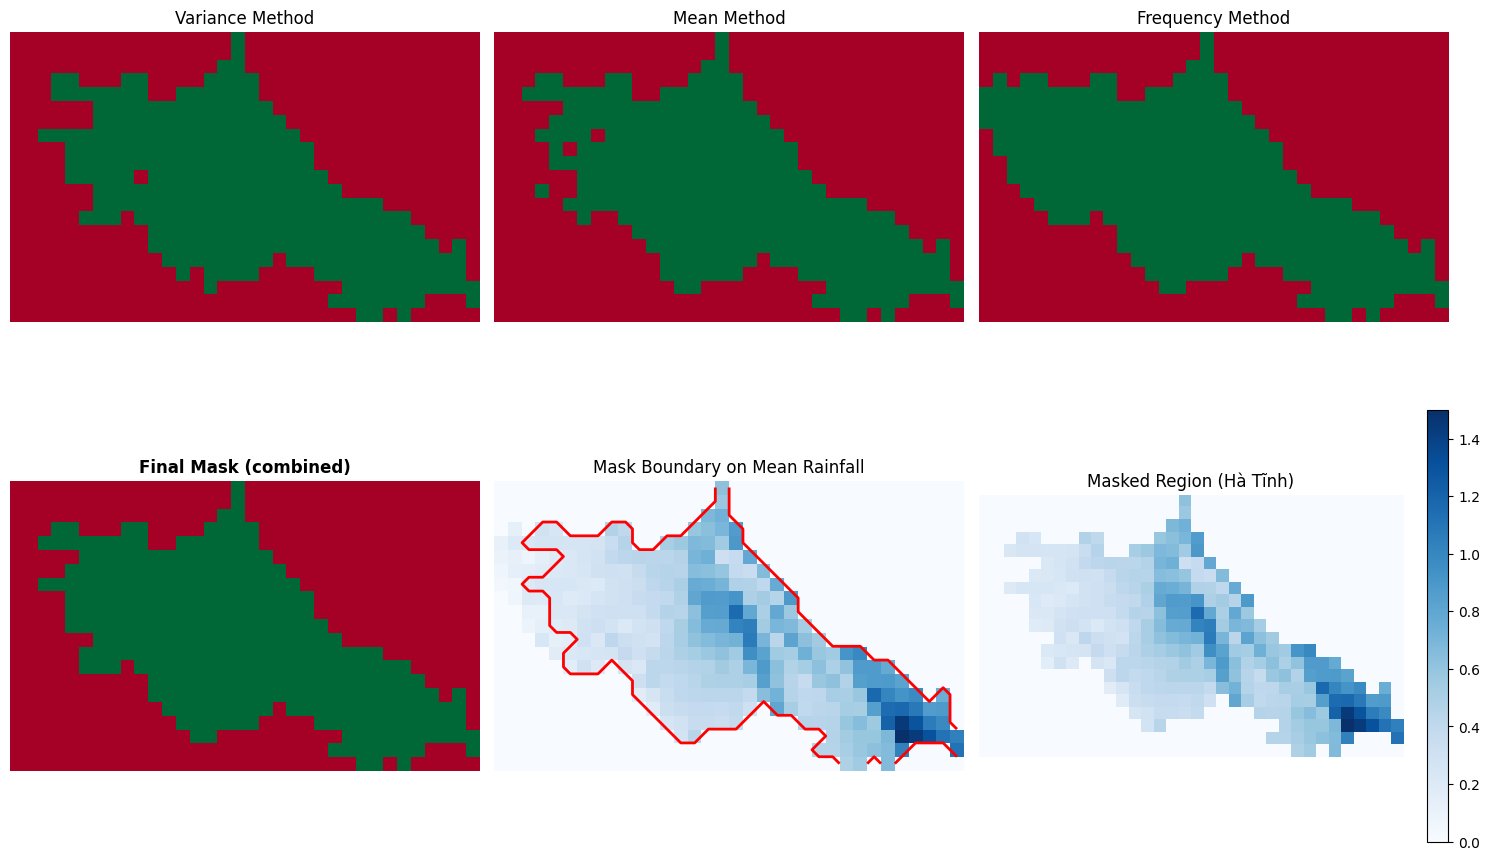


VALIDATING MASK
✓ Coverage looks good (41.5%)

Rainfall statistics:
  Inside mask:  mean=2.9589, std=3.3663
  Outside mask: mean=1.0457, std=0.2081
✓ Inside region has higher rainfall (good!)

✓ Validation plot saved to 'mask_validation.png'


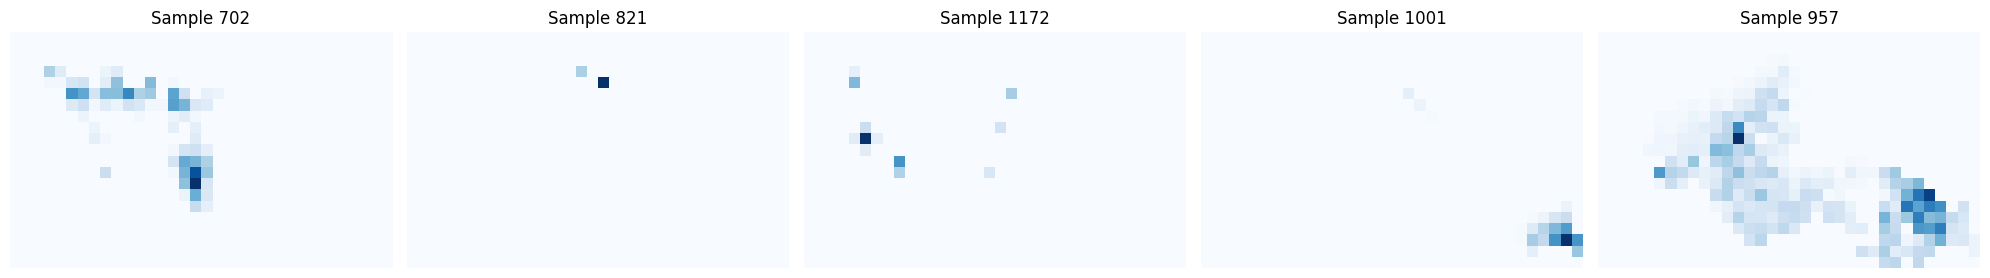


✓ Mask saved to 'hatinh_mask.npy'

METHOD 2: COMPARE ALL METHODS

HOW TO USE IN YOUR TRAINING CODE

# Load mask
mask = np.load('hatinh_mask.npy')

# In your training code, replace this section:
try:
    mask = np.load('/kaggle/input/YOUR_MASK_DATASET/hatinh_mask.npy')
except FileNotFoundError:
    mask = create_hatinh_mask_auto(Y, method='combined', visualize=True)
    np.save('hatinh_mask.npy', mask)

# The rest stays the same!


✓ Done! Check the visualization to verify mask quality.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

def create_hatinh_mask_auto(Y, method='combined', visualize=True):
    """
    Tự động tạo mask Hà Tĩnh từ dữ liệu Y
    
    Parameters:
    -----------
    Y : numpy array shape (N, H, W)
        Dữ liệu rainfall target
    method : str
        'variance' - dựa trên độ biến thiên
        'mean' - dựa trên giá trị trung bình
        'combined' - kết hợp nhiều phương pháp (khuyến nghị)
    visualize : bool
        Có hiển thị kết quả không
    
    Returns:
    --------
    mask : numpy array shape (H, W)
        Mask với giá trị 1 (Hà Tĩnh) và 0 (ngoài rìa)
    """
    print(f"\n{'='*60}")
    print(f"AUTO-CREATE MASK FOR HÀ TĨNH")
    print(f"{'='*60}")
    print(f"Input Y shape: {Y.shape}")
    print(f"Method: {method}")
    
    H, W = Y.shape[1], Y.shape[2]
    
    # Method 1: Variance-based (vùng có rainfall thay đổi nhiều)
    variance_map = np.var(Y, axis=0)
    var_threshold = np.percentile(variance_map[variance_map > 0], 10)  # Bottom 10%
    mask_variance = (variance_map > var_threshold).astype(np.float32)
    print(f"\n1. Variance method:")
    print(f"   Threshold: {var_threshold:.6f}")
    print(f"   Valid pixels: {mask_variance.sum():.0f}/{mask_variance.size}")
    
    # Method 2: Mean-based (vùng có rainfall trung bình cao hơn)
    mean_map = np.mean(Y, axis=0)
    mean_threshold = np.percentile(mean_map[mean_map > 0], 10)
    mask_mean = (mean_map > mean_threshold).astype(np.float32)
    print(f"\n2. Mean method:")
    print(f"   Threshold: {mean_threshold:.6f}")
    print(f"   Valid pixels: {mask_mean.sum():.0f}/{mask_mean.size}")
    
    # Method 3: Frequency-based (vùng có rainfall > 0 thường xuyên)
    nonzero_freq = np.sum(Y > 1e-3, axis=0) / len(Y)
    freq_threshold = 0.05  # Ít nhất 5% samples có mưa
    mask_freq = (nonzero_freq > freq_threshold).astype(np.float32)
    print(f"\n3. Frequency method:")
    print(f"   Threshold: {freq_threshold:.2%}")
    print(f"   Valid pixels: {mask_freq.sum():.0f}/{mask_freq.size}")
    
    # Select method
    if method == 'variance':
        mask = mask_variance
    elif method == 'mean':
        mask = mask_mean
    elif method == 'frequency':
        mask = mask_freq
    elif method == 'combined':
        # Kết hợp: pixel phải thỏa ít nhất 2/3 điều kiện
        mask_combined = (mask_variance + mask_mean + mask_freq) >= 2
        mask = mask_combined.astype(np.float32)
        print(f"\n4. Combined method (≥2/3 criteria):")
        print(f"   Valid pixels: {mask.sum():.0f}/{mask.size}")
    else:
        raise ValueError(f"Unknown method: {method}")
    
    # Post-processing: Remove small isolated regions
    # Fill holes inside large regions
    mask = ndimage.binary_fill_holes(mask).astype(np.float32)
    
    # Remove small isolated pixels (noise)
    labeled, num_features = ndimage.label(mask)
    if num_features > 1:
        sizes = ndimage.sum(mask, labeled, range(num_features + 1))
        # Keep only regions with size > 5% of largest region
        max_size = sizes.max()
        mask_cleaned = np.zeros_like(mask)
        for i in range(1, num_features + 1):
            if sizes[i] > max_size * 0.05:
                mask_cleaned[labeled == i] = 1
        mask = mask_cleaned
        print(f"\n5. Post-processing:")
        print(f"   Removed {num_features - 1} small regions")
    
    # Final statistics
    valid = mask.sum()
    total = mask.size
    print(f"\n{'='*60}")
    print(f"FINAL MASK STATISTICS")
    print(f"{'='*60}")
    print(f"Valid pixels (Hà Tĩnh):     {valid:.0f}")
    print(f"Invalid pixels (outside):    {(mask == 0).sum():.0f}")
    print(f"Coverage:                    {valid/total*100:.2f}%")
    print(f"Shape:                       {mask.shape}")
    
    # Visualization
    if visualize:
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        
        # Row 1: Intermediate masks
        axes[0, 0].imshow(mask_variance, cmap='RdYlGn')
        axes[0, 0].set_title('Variance Method')
        axes[0, 0].axis('off')
        
        axes[0, 1].imshow(mask_mean, cmap='RdYlGn')
        axes[0, 1].set_title('Mean Method')
        axes[0, 1].axis('off')
        
        axes[0, 2].imshow(mask_freq, cmap='RdYlGn')
        axes[0, 2].set_title('Frequency Method')
        axes[0, 2].axis('off')
        
        # Row 2: Final mask and overlays
        axes[1, 0].imshow(mask, cmap='RdYlGn')
        axes[1, 0].set_title(f'Final Mask ({method})', fontweight='bold')
        axes[1, 0].axis('off')
        
        # Overlay mask on mean rainfall
        mean_rainfall = np.mean(Y, axis=0)
        axes[1, 1].imshow(mean_rainfall, cmap='Blues')
        axes[1, 1].contour(mask, levels=[0.5], colors='red', linewidths=2)
        axes[1, 1].set_title('Mask Boundary on Mean Rainfall')
        axes[1, 1].axis('off')
        
        # Show masked region only
        masked_rainfall = mean_rainfall * mask
        im = axes[1, 2].imshow(masked_rainfall, cmap='Blues')
        axes[1, 2].set_title('Masked Region (Hà Tĩnh)')
        axes[1, 2].axis('off')
        plt.colorbar(im, ax=axes[1, 2], fraction=0.046)
        
        plt.tight_layout()
        plt.savefig('hatinh_mask_creation.png', dpi=150, bbox_inches='tight')
        print(f"\n✓ Visualization saved to 'hatinh_mask_creation.png'")
        plt.show()
    
    return mask


def compare_mask_methods(Y, save_path='mask_comparison.png'):
    """So sánh các phương pháp tạo mask"""
    methods = ['variance', 'mean', 'frequency', 'combined']
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    axes = axes.flatten()
    
    for i, method in enumerate(methods):
        mask = create_hatinh_mask_auto(Y, method=method, visualize=False)
        
        mean_rainfall = np.mean(Y, axis=0)
        axes[i].imshow(mean_rainfall, cmap='Blues', alpha=0.6)
        axes[i].contour(mask, levels=[0.5], colors='red', linewidths=2)
        axes[i].set_title(f'{method.upper()}\n({mask.sum():.0f} pixels)', 
                         fontweight='bold')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"\n✓ Comparison saved to '{save_path}'")
    plt.show()


def validate_mask(mask, Y, num_samples=5):
    """Kiểm tra mask có hợp lý không"""
    print(f"\n{'='*60}")
    print(f"VALIDATING MASK")
    print(f"{'='*60}")
    
    # Check 1: Coverage
    coverage = mask.sum() / mask.size * 100
    if coverage < 20:
        print(f"⚠️  WARNING: Coverage too low ({coverage:.1f}%)")
    elif coverage > 80:
        print(f"⚠️  WARNING: Coverage too high ({coverage:.1f}%)")
    else:
        print(f"✓ Coverage looks good ({coverage:.1f}%)")
    
    # Check 2: Rainfall distribution
    Y_inside = Y[:, mask == 1]
    Y_outside = Y[:, mask == 0]
    
    mean_inside = np.mean(Y_inside[Y_inside > 0])
    mean_outside = np.mean(Y_outside[Y_outside > 0]) if Y_outside.size > 0 else 0
    
    print(f"\nRainfall statistics:")
    print(f"  Inside mask:  mean={mean_inside:.4f}, std={np.std(Y_inside):.4f}")
    print(f"  Outside mask: mean={mean_outside:.4f}, std={np.std(Y_outside):.4f}")
    
    if mean_inside > mean_outside * 1.2:
        print(f"✓ Inside region has higher rainfall (good!)")
    else:
        print(f"⚠️  Rainfall difference not clear")
    
    # Check 3: Visual samples
    fig, axes = plt.subplots(1, num_samples, figsize=(4*num_samples, 4))
    indices = np.random.choice(len(Y), num_samples, replace=False)
    
    for i, idx in enumerate(indices):
        masked_y = Y[idx] * mask
        axes[i].imshow(masked_y, cmap='Blues')
        axes[i].set_title(f'Sample {idx}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig('mask_validation.png', dpi=150, bbox_inches='tight')
    print(f"\n✓ Validation plot saved to 'mask_validation.png'")
    plt.show()


# ==================== USAGE EXAMPLE ====================
if __name__ == "__main__":
    # Load your data
    Y = np.load('Data/data_np/y_hatinh.npy')
    
    print(f"Loaded Y: {Y.shape}")
    print(f"Y range: [{Y.min():.3f}, {Y.max():.3f}]")
    
    # Method 1: Quick - Use combined method (khuyến nghị)
    print("\n" + "="*60)
    print("METHOD 1: COMBINED (RECOMMENDED)")
    print("="*60)
    mask = create_hatinh_mask_auto(Y, method='combined', visualize=True)
    
    # Validate
    validate_mask(mask, Y, num_samples=5)
    
    # Save mask
    np.save('Data/datamask/hatinh_mask_y.npy', mask)
    print(f"\n✓ Mask saved to 'hatinh_mask.npy'")
    
    # Method 2: Compare all methods to choose best one
    print("\n" + "="*60)
    print("METHOD 2: COMPARE ALL METHODS")
    print("="*60)
    # compare_mask_methods(Y, save_path='mask_comparison.png')
    
    # Print usage instructions
    print(f"\n{'='*60}")
    print("HOW TO USE IN YOUR TRAINING CODE")
    print(f"{'='*60}")
    print("""
# Load mask
mask = np.load('hatinh_mask.npy')

# In your training code, replace this section:
try:
    mask = np.load('/kaggle/input/YOUR_MASK_DATASET/hatinh_mask.npy')
except FileNotFoundError:
    mask = create_hatinh_mask_auto(Y, method='combined', visualize=True)
    np.save('hatinh_mask.npy', mask)

# The rest stays the same!
""")
    
    print("\n✓ Done! Check the visualization to verify mask quality.")

Loaded X: (1223, 12, 21, 34)
X range: [0.000, 1.000]

METHOD 1: COMBINED (RECOMMENDED)

AUTO-CREATE MASK FOR HÀ TĨNH FROM X DATA
Input X shape: (1223, 12, 21, 34)
Method: combined

1. Variance method:
   Threshold: 0.000000
   Valid pixels: 321/714

2. Mean method:
   Threshold: 0.002805
   Valid pixels: 321/714

3. Frequency method:
   Threshold: 50.00%
   Valid pixels: 714/714

4. Combined method (≥2/3 criteria):
   Valid pixels: 321/714

FINAL MASK STATISTICS
Valid pixels (Hà Tĩnh):     321
Invalid pixels (outside):    393
Coverage:                    44.96%
Shape:                       (21, 34)


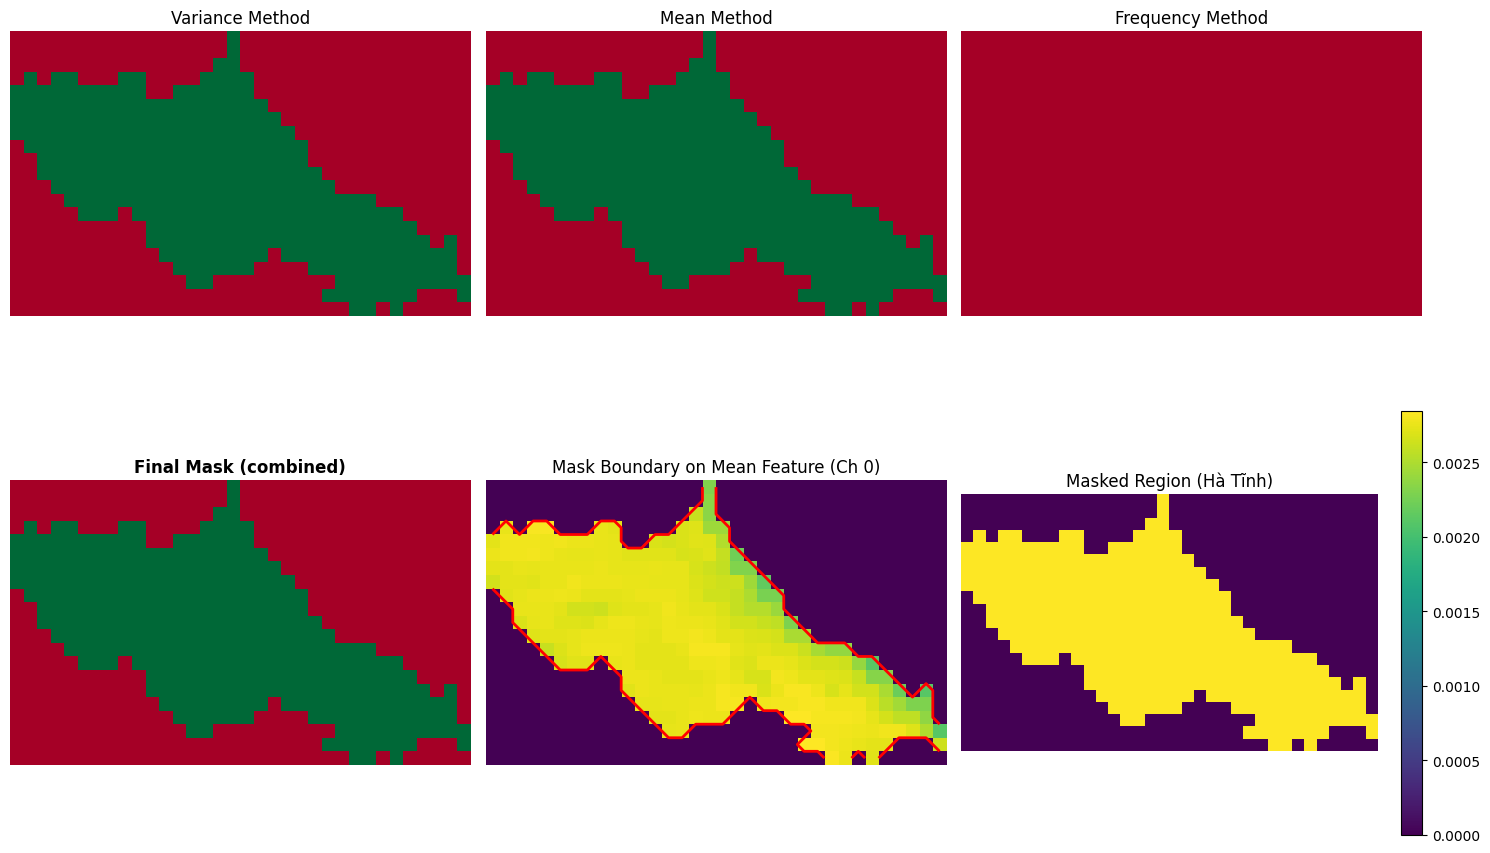


VALIDATING MASK
✓ Coverage looks good (45.0%)

Feature statistics:
  Inside mask:  mean=0.0276, std=0.0129
  Outside mask: mean=0.0028, std=0.0000

✓ Validation plot saved to 'mask_validation_X.png'


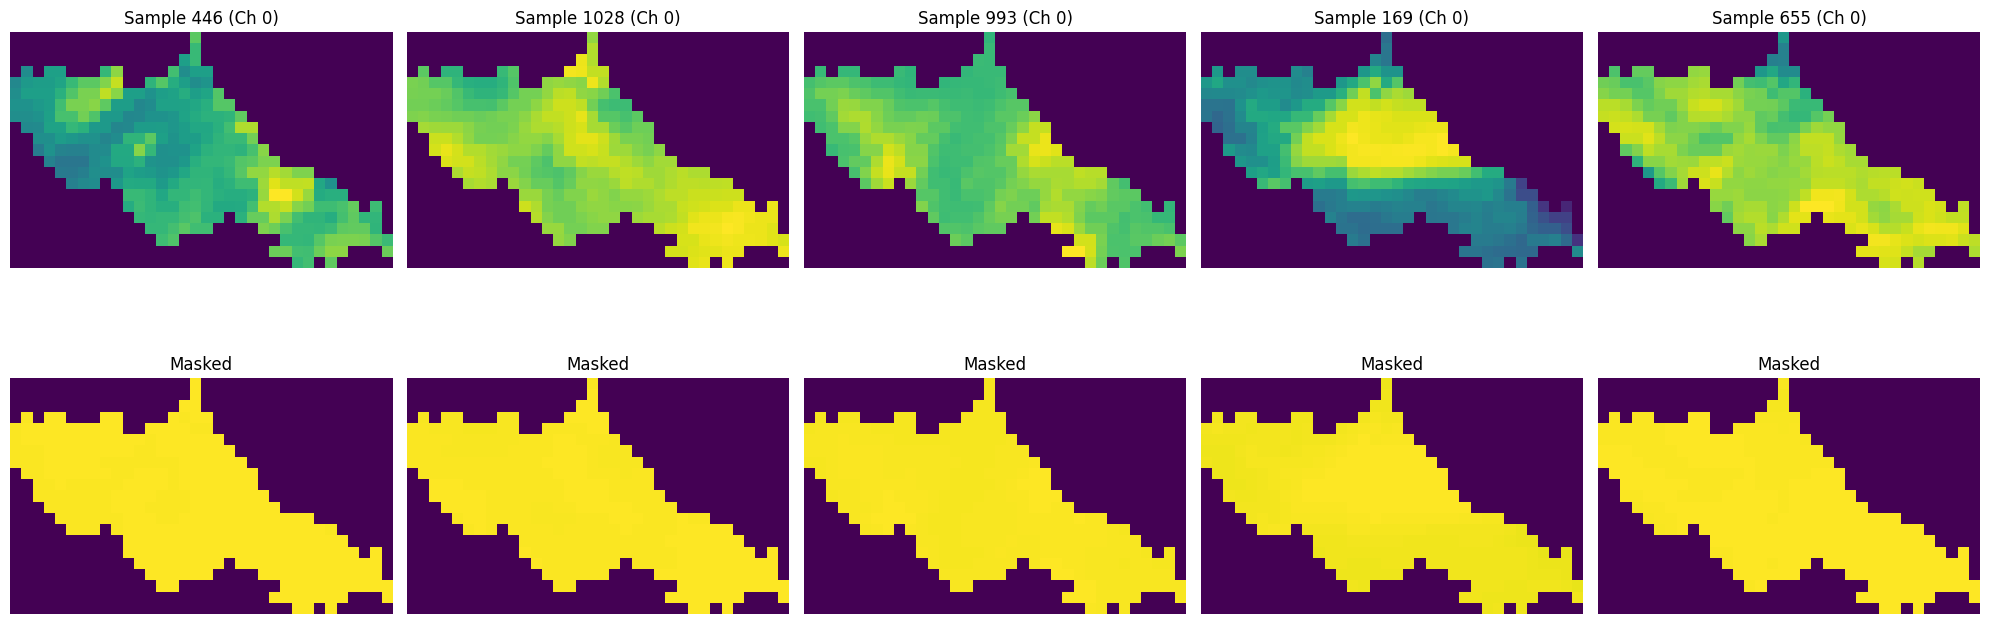


✓ Mask saved to 'hatinh_mask_from_X.npy'

METHOD 2: COMPARE ALL METHODS

AUTO-CREATE MASK FOR HÀ TĨNH FROM X DATA
Input X shape: (1223, 12, 21, 34)
Method: variance

1. Variance method:
   Threshold: 0.000000
   Valid pixels: 321/714

2. Mean method:
   Threshold: 0.002805
   Valid pixels: 321/714

3. Frequency method:
   Threshold: 50.00%
   Valid pixels: 714/714

FINAL MASK STATISTICS
Valid pixels (Hà Tĩnh):     321
Invalid pixels (outside):    393
Coverage:                    44.96%
Shape:                       (21, 34)

AUTO-CREATE MASK FOR HÀ TĨNH FROM X DATA
Input X shape: (1223, 12, 21, 34)
Method: mean

1. Variance method:
   Threshold: 0.000000
   Valid pixels: 321/714

2. Mean method:
   Threshold: 0.002805
   Valid pixels: 321/714

3. Frequency method:
   Threshold: 50.00%
   Valid pixels: 714/714

FINAL MASK STATISTICS
Valid pixels (Hà Tĩnh):     321
Invalid pixels (outside):    393
Coverage:                    44.96%
Shape:                       (21, 34)

AUTO-CREATE MASK

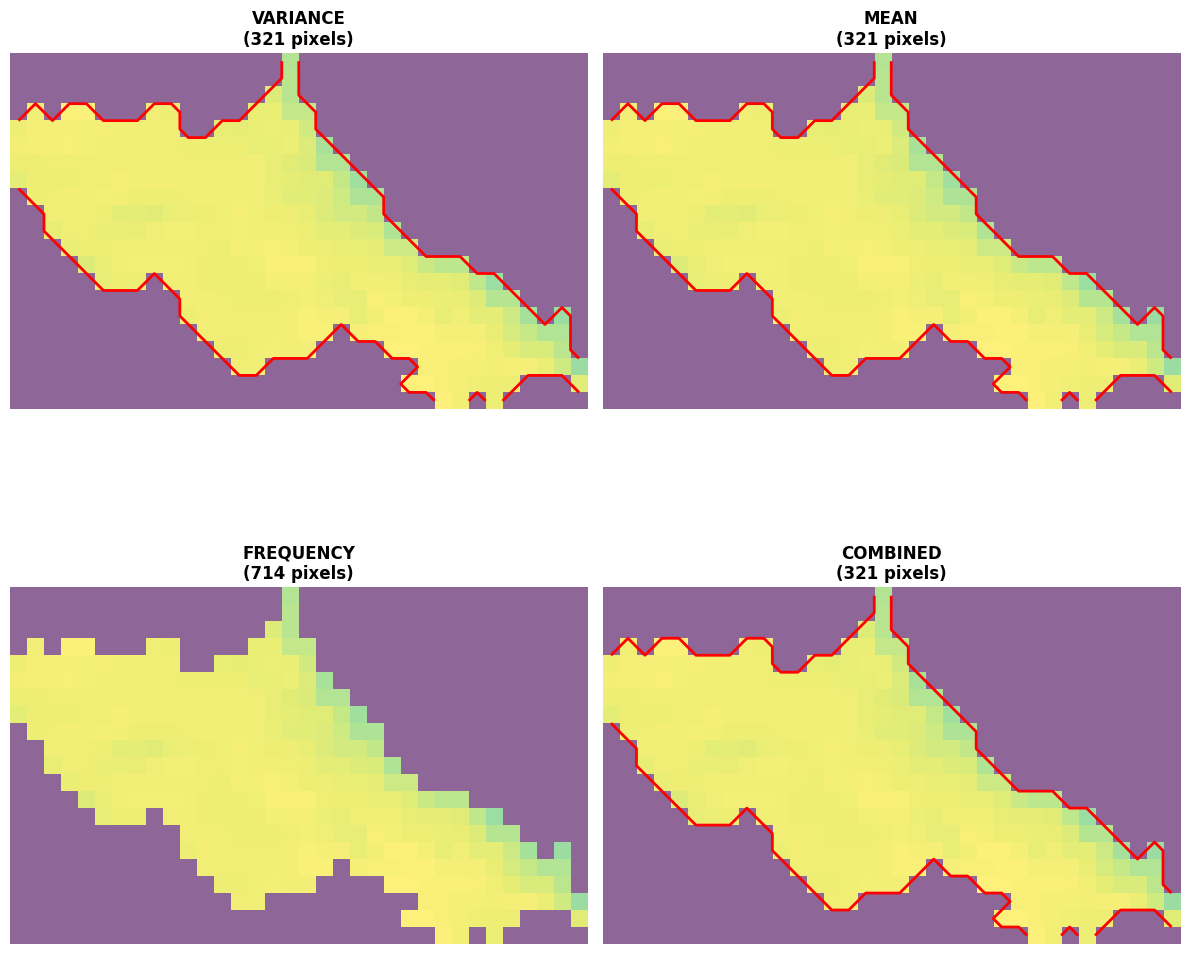


HOW TO USE IN YOUR TRAINING CODE

# Load mask
mask = np.load('hatinh_mask_from_X.npy')

# Apply mask to X data
# mask shape: (21, 34)
# X shape: (N, 12, 21, 34)

# Method 1: Mask all channels
X_masked = X * mask[None, None, :, :]  # Broadcasting

# Method 2: Extract only valid pixels
# valid_pixels = mask == 1
# X_valid = X[:, :, valid_pixels]  # Shape: (N, 12, num_valid_pixels)

# In your loss function:
# loss = criterion(pred * mask, target * mask)


✓ Done! Check the visualization to verify mask quality.

Mask shape: (21, 34)
Expected X spatial dims: (21, 34) ✓


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

def create_hatinh_mask_from_X(X, method='combined', visualize=True):
    """
    Tự động tạo mask Hà Tĩnh từ dữ liệu X (input features)
    
    Parameters:
    -----------
    X : numpy array shape (N, C, H, W)
        Dữ liệu input features (N samples, C channels, H height, W width)
    method : str
        'variance' - dựa trên độ biến thiên
        'mean' - dựa trên giá trị trung bình
        'combined' - kết hợp nhiều phương pháp (khuyến nghị)
    visualize : bool
        Có hiển thị kết quả không
    
    Returns:
    --------
    mask : numpy array shape (H, W)
        Mask với giá trị 1 (Hà Tĩnh) và 0 (ngoài rìa)
    """
    print(f"\n{'='*60}")
    print(f"AUTO-CREATE MASK FOR HÀ TĨNH FROM X DATA")
    print(f"{'='*60}")
    print(f"Input X shape: {X.shape}")
    print(f"Method: {method}")
    
    N, C, H, W = X.shape
    
    # Tính toán trên tất cả channels và samples
    # Reshape to (N*C, H, W) để xử lý tất cả channels cùng lúc
    X_reshaped = X.reshape(N * C, H, W)
    
    # Method 1: Variance-based (vùng có độ biến thiên cao)
    variance_map = np.var(X_reshaped, axis=0)
    var_threshold = np.percentile(variance_map[variance_map > 0], 10)  # Bottom 10%
    mask_variance = (variance_map > var_threshold).astype(np.float32)
    print(f"\n1. Variance method:")
    print(f"   Threshold: {var_threshold:.6f}")
    print(f"   Valid pixels: {mask_variance.sum():.0f}/{mask_variance.size}")
    
    # Method 2: Mean-based (vùng có giá trị trung bình khác biệt)
    mean_map = np.mean(X_reshaped, axis=0)
    mean_threshold = np.percentile(mean_map[mean_map > 0], 10)
    mask_mean = (mean_map > mean_threshold).astype(np.float32)
    print(f"\n2. Mean method:")
    print(f"   Threshold: {mean_threshold:.6f}")
    print(f"   Valid pixels: {mask_mean.sum():.0f}/{mask_mean.size}")
    
    # Method 3: Non-zero frequency (vùng có dữ liệu khác 0 thường xuyên)
    nonzero_freq = np.sum(np.abs(X_reshaped) > 1e-3, axis=0) / len(X_reshaped)
    freq_threshold = 0.5  # Ít nhất 50% samples có giá trị khác 0
    mask_freq = (nonzero_freq > freq_threshold).astype(np.float32)
    print(f"\n3. Frequency method:")
    print(f"   Threshold: {freq_threshold:.2%}")    
    print(f"   Valid pixels: {mask_freq.sum():.0f}/{mask_freq.size}")
    
    # Select method
    if method == 'variance':
        mask = mask_variance
    elif method == 'mean':
        mask = mask_mean
    elif method == 'frequency':
        mask = mask_freq
    elif method == 'combined':
        # Kết hợp: pixel phải thỏa ít nhất 2/3 điều kiện
        mask_combined = (mask_variance + mask_mean + mask_freq) >= 2
        mask = mask_combined.astype(np.float32)
        print(f"\n4. Combined method (≥2/3 criteria):")
        print(f"   Valid pixels: {mask.sum():.0f}/{mask.size}")
    else:
        raise ValueError(f"Unknown method: {method}")
    
    # Post-processing: Remove small isolated regions
    # Fill holes inside large regions
    mask = ndimage.binary_fill_holes(mask).astype(np.float32)
    
    # Remove small isolated pixels (noise)
    labeled, num_features = ndimage.label(mask)
    if num_features > 1:
        sizes = ndimage.sum(mask, labeled, range(num_features + 1))
        # Keep only regions with size > 5% of largest region
        max_size = sizes.max()
        mask_cleaned = np.zeros_like(mask)
        for i in range(1, num_features + 1):
            if sizes[i] > max_size * 0.05:
                mask_cleaned[labeled == i] = 1
        mask = mask_cleaned
        print(f"\n5. Post-processing:")
        print(f"   Removed {num_features - 1} small regions")
    
    # Final statistics
    valid = mask.sum()
    total = mask.size
    print(f"\n{'='*60}")
    print(f"FINAL MASK STATISTICS")
    print(f"{'='*60}")
    print(f"Valid pixels (Hà Tĩnh):     {valid:.0f}")
    print(f"Invalid pixels (outside):    {(mask == 0).sum():.0f}")
    print(f"Coverage:                    {valid/total*100:.2f}%")
    print(f"Shape:                       {mask.shape}")
    
    # Visualization
    if visualize:
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        
        # Row 1: Intermediate masks
        axes[0, 0].imshow(mask_variance, cmap='RdYlGn')
        axes[0, 0].set_title('Variance Method')
        axes[0, 0].axis('off')
        
        axes[0, 1].imshow(mask_mean, cmap='RdYlGn')
        axes[0, 1].set_title('Mean Method')
        axes[0, 1].axis('off')
        
        axes[0, 2].imshow(mask_freq, cmap='RdYlGn')
        axes[0, 2].set_title('Frequency Method')
        axes[0, 2].axis('off')
        
        # Row 2: Final mask and overlays
        axes[1, 0].imshow(mask, cmap='RdYlGn')
        axes[1, 0].set_title(f'Final Mask ({method})', fontweight='bold')
        axes[1, 0].axis('off')
        
        # Overlay mask on mean of first channel
        mean_feature = np.mean(X[:, 0, :, :], axis=0)  # Use first channel
        axes[1, 1].imshow(mean_feature, cmap='viridis')
        axes[1, 1].contour(mask, levels=[0.5], colors='red', linewidths=2)
        axes[1, 1].set_title('Mask Boundary on Mean Feature (Ch 0)')
        axes[1, 1].axis('off')
        
        # Show masked region only
        masked_feature = mean_feature * mask
        im = axes[1, 2].imshow(masked_feature, cmap='viridis')
        axes[1, 2].set_title('Masked Region (Hà Tĩnh)')
        axes[1, 2].axis('off')
        plt.colorbar(im, ax=axes[1, 2], fraction=0.046)
        
        plt.tight_layout()
        # plt.savefig('hatinh_mask_from_X.png', dpi=150, bbox_inches='tight')
        # print(f"\n✓ Visualization saved to 'hatinh_mask_from_X.png'")
        plt.show()
    
    return mask


def compare_mask_methods(X, save_path='mask_comparison_X.png'):
    """So sánh các phương pháp tạo mask từ X"""
    methods = ['variance', 'mean', 'frequency', 'combined']
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    axes = axes.flatten()
    
    for i, method in enumerate(methods):
        mask = create_hatinh_mask_from_X(X, method=method, visualize=False)
        
        mean_feature = np.mean(X[:, 0, :, :], axis=0)
        axes[i].imshow(mean_feature, cmap='viridis', alpha=0.6)
        axes[i].contour(mask, levels=[0.5], colors='red', linewidths=2)
        axes[i].set_title(f'{method.upper()}\n({mask.sum():.0f} pixels)', 
                         fontweight='bold')
        axes[i].axis('off')
    
    plt.tight_layout()
    # plt.savefig(save_path, dpi=150, bbox_inches='tight')
    # print(f"\n✓ Comparison saved to '{save_path}'")
    plt.show()


def validate_mask_X(mask, X, num_samples=5):
    """Kiểm tra mask có hợp lý không với dữ liệu X"""
    print(f"\n{'='*60}")
    print(f"VALIDATING MASK")
    print(f"{'='*60}")
    
    # Check 1: Coverage
    coverage = mask.sum() / mask.size * 100
    if coverage < 20:
        print(f"⚠️  WARNING: Coverage too low ({coverage:.1f}%)")
    elif coverage > 80:
        print(f"⚠️  WARNING: Coverage too high ({coverage:.1f}%)")
    else:
        print(f"✓ Coverage looks good ({coverage:.1f}%)")
    
    # Check 2: Feature distribution
    # Average over all channels
    X_mean = np.mean(X, axis=1)  # Average over channels -> (N, H, W)
    
    X_inside = X_mean[:, mask == 1]
    X_outside = X_mean[:, mask == 0]
    
    mean_inside = np.mean(X_inside)
    mean_outside = np.mean(X_outside) if X_outside.size > 0 else 0
    
    print(f"\nFeature statistics:")
    print(f"  Inside mask:  mean={mean_inside:.4f}, std={np.std(X_inside):.4f}")
    print(f"  Outside mask: mean={mean_outside:.4f}, std={np.std(X_outside):.4f}")
    
    # Check 3: Visual samples
    fig, axes = plt.subplots(2, num_samples, figsize=(4*num_samples, 8))
    indices = np.random.choice(len(X), num_samples, replace=False)
    
    for i, idx in enumerate(indices):
        # Original (first channel)
        axes[0, i].imshow(X[idx, 0], cmap='viridis')
        axes[0, i].set_title(f'Sample {idx} (Ch 0)')
        axes[0, i].axis('off')
        
        # Masked (first channel)
        masked_x = X[idx, 0] * mask
        axes[1, i].imshow(masked_x, cmap='viridis')
        axes[1, i].set_title(f'Masked')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.savefig('mask_validation_X.png', dpi=150, bbox_inches='tight')
    print(f"\n✓ Validation plot saved to 'mask_validation_X.png'")
    plt.show()


# ==================== USAGE EXAMPLE ====================
if __name__ == "__main__":
    # Load your data
    X = np.load('Data/data_np/x_hatinh.npy')
    
    print(f"Loaded X: {X.shape}")
    print(f"X range: [{X.min():.3f}, {X.max():.3f}]")
    
    # Method 1: Quick - Use combined method (khuyến nghị)
    print("\n" + "="*60)
    print("METHOD 1: COMBINED (RECOMMENDED)")
    print("="*60)
    mask = create_hatinh_mask_from_X(X, method='combined', visualize=True)
    
    # Validate
    validate_mask_X(mask, X, num_samples=5)
    
    # Save mask
    np.save('Data/datamask/hatinh_mask_x.npy', mask)
    print(f"\n✓ Mask saved to 'hatinh_mask_from_X.npy'")
    
    # Method 2: Compare all methods to choose best one
    print("\n" + "="*60)
    print("METHOD 2: COMPARE ALL METHODS")
    print("="*60)
    compare_mask_methods(X, save_path='mask_comparison_X.png')
    
    # Print usage instructions
    print(f"\n{'='*60}")
    print("HOW TO USE IN YOUR TRAINING CODE")
    print(f"{'='*60}")
    print("""
# Load mask
mask = np.load('hatinh_mask_from_X.npy')

# Apply mask to X data
# mask shape: (21, 34)
# X shape: (N, 12, 21, 34)

# Method 1: Mask all channels
X_masked = X * mask[None, None, :, :]  # Broadcasting

# Method 2: Extract only valid pixels
# valid_pixels = mask == 1
# X_valid = X[:, :, valid_pixels]  # Shape: (N, 12, num_valid_pixels)

# In your loss function:
# loss = criterion(pred * mask, target * mask)
""")
    
    print("\n✓ Done! Check the visualization to verify mask quality.")
    print(f"\nMask shape: {mask.shape}")
    print(f"Expected X spatial dims: (21, 34) ✓")